In [1]:
import mdtraj as md
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
import pandas as pd

In [2]:
def _dist_atom_selection(topology, atom1, atom2, verbose, unpythonize):
    """
    Function takes a topology file and residue selection and verifies if
    the lattter is possible. It also returns the C-alpha atom selection
    Input:
        topology: 
            mdtraj.Topology or string
            Either mdtraj.Topology object or path to trajectory
            to be loaded
        residue_selection:
            string or list with integers
            String will be interpreted with the Mdtraj atom
            selection language. The list will be treated as
            atom number
        selection (by default True):
            boolean
            if true the function will try to return the residue/
            atom selection
    Output:
        atom_subset
            numpy.array 
            array with all the atom numbers corresponding to selection
        md_topology
            mdtraj.core.topology.Topology object of protein 
    """
    ## First have to load all the inputs if they are defined by a path
    if isinstance(topology, str):
        if os.path.exists(topology):
            try:
                md_topology = md.load_topology(topology)
            except:
                sys.exit('Make sure you have provided a valid path to topology file!')
            else:
                if verbose > 0:
                    print 'The following topology file was succesfully loaded: \n %s \n' %(md_topology)

    elif isinstance(topology, md.core.topology.Topology):
        md_topology = topology
        if verbose > 0:
            print 'The following topology file was succesfully loaded: \n %s \n' %(md_topology)
    else:
        sys.exit('Invalid input! Must be a valid path to topology file or mdtraj.Topology object')
    
    ## check chosen atoms
    if isinstance(atom1, str):
        #try:
            atom_subset1 = md_topology.select(atom1)
        #except:
         #   sys.exit('Invalid atom selection!')
        #else:
         #   if verbose > 0:
          #      print 'Atom1 number: %s' %(atom_subset1[0] + 1)
    
    
    elif isinstance(atom1, int):
        atom1 = atom1 - 1
        try:
            atom_subset1 = []
            if atom1 < md_topology.n_atoms:
                atom_subset1.append(atom1)
        except:
            sys.exit('Atom selection invalid for given topology!')
        else:
            if verbose > 0:
                print 'Atom1 number: %s' %(atom_subset1[0] + 1)
                
    else:
        sys.exit('Invalid atom selection, you need to provide a string or an integer')

    if isinstance(atom2, str):
        #try:
            atom_subset2 = md_topology.select(atom2)
        #except:
         #   sys.exit('Invalid atom selection!')
        #else:
            #if verbose > 0:
             #   print 'Atom2 number: %s' %(atom_subset2[0] + 1)                   
                
    elif isinstance(atom2, int):
        atom2 = atom2 - 1
        try:
            atom_subset2 = []
            if atom2 < md_topology.n_atoms:
                atom_subset2.append(atom2)
        except:
            sys.exit('Invalid atom selection!')
        else:
            if verbose > 0:
                print 'Atom2 number: %s' %(atom_subset2[0] + 1)
                
    else:
        sys.exit('Invalid atom selection, you need to provide a string or an integer')

    pair = np.append(atom_subset1, atom_subset2).reshape(1,2)
    
    # should work until 1109
    if unpythonize:
        # rename residues (still testing)
        final_resid_name = []
        for i in md_topology.subset(pair).atoms:
            residues = str(i)
            # position to substitute
            pos = []
            num = []
            for i in range(len(residues)):    
                # skip first three letters
                if i<6 and residues[i].isdigit():
                    pos.append(i)
                    num.append(int(residues[i]))
            if len(pos) == 1:
                if num[-1] < 9:
                    num[-1] += 1
                else:
                    num[-1] = 10
            if len(pos) == 2:
                if num[-1] < 9:
                    num[-1] += 1
                else:
                    num[-1] = 0
                    num[0] += 1
            if len(pos) == 3:
                if num[-1] < 9:
                    num[-1] += 1
                else:
                    num[1] += 1
                    num[-1] = 0
            z = 0
            residues = list(residues)
            for j in pos:
                residues[j] = str(num[z])
                z+=1
            final_resid_name.append("".join(residues))
        final_resid = " - ".join(final_resid_name)
    
    if verbose > 0:
        print 'Calculating distance between following atoms: %s \n' %(final_resid)
    
    
    return md_topology, pair, final_resid

In [3]:
def _dist_atom_load(md_topology, trajectory, pair, verbose, chunk):
    
    # first create a list with all the paths that are needed
    try:
        trajectory_path = os.listdir(trajectory)
    except:
        sys.exit('Make sure you have provided a string for a valid path to a trajectory file!')
    else:
        if verbose > 0:
            print 'Loading trajectories from the following files: '
            for trajectory_i in trajectory_path:
                print trajectory_i
    
    all_distances = []
    sim_time = []
    
    #try:
    for file_i in trajectory_path:
            for chunk_i in md.iterload(trajectory + file_i, chunk, top=md_topology):
                        
                sim_time.append(chunk_i.time)

                if verbose > 1:
                    print 'Successfully loaded trajectory: \n %s' %(chunk_i)

                all_distances.append(md.compute_distances(chunk_i, pair))
                        
                        
    all_distances_np = np.concatenate(all_distances) * 10
    #except:
     #   sys.exit('Make sure you provided a valid path to a folder with trajectory files!')
    #else:
     #   print '\nSuccesfully calculated atom distances in %s frames!' %(all_distances_np.shape[0])
 
    sim_time = np.concatenate(sim_time) / 1000
    
    return all_distances_np.reshape(all_distances_np.shape[0]), sim_time

In [4]:
def main(topology, trajectory, atom1, atom2, verbose = 1, chunk = 100, unpythonize = True, plot_dist = True):
    """
    Function to calculate distance between two
    atoms and plot pdf 
    """
    
    if verbose > 0:
    # timer for the whole function
        start = time.time()
        
    # now load topology and verify selection by calling _dist_atom_selection()
    md_topology, pair, final_residues = _dist_atom_selection(topology, atom1, atom2, verbose, unpythonize)
    
    # load trajectories and calculate distances
    distance, sim_time  = _dist_atom_load(md_topology, trajectory, pair, verbose, chunk)
    
    if plot_dist:
        # plots:
        # distance as a function of time:
        plt.figure(figsize=(12,12))
        plt.plot(sim_time, distance, c='k', label = 'Distance')
        plt.plot(sim_time, pd.rolling_mean(pd.DataFrame(distance), 50), c='red', label = '50 frame rolling mean')
        plt.legend(loc='best', prop={'size':12})
        plt.title('Distance between %s' % final_residues, size = 24)
        plt.xlabel('Time (ns)', size = 14)
        plt.ylabel('Distance (${\AA}$)', size = 14)
        plt.show()

        # distance density plot
        plt.figure(figsize = (12,12)) 
        ax = sns.distplot(distance, hist=False, rug=False)
        ax.set_xlabel('Distance (${\AA}$)', size = 16)
        ax.set_ylabel('Density', size = 16)
        ax.set_title('Distance between %s' % final_residues, size = 24)
        plt.show()
    
    total_trajectory_time = sim_time[-1] - sim_time[0] + 0.02
    
    if verbose > 0:
        print 'Total execution time: %.2f seconds \n' %(time.time() - start)
        print 'Total simulation time of all frames: %.2f nanoseconds' %(total_trajectory_time)

    return distance, final_residues, total_trajectory_time

In [5]:
traj_list = ['/Users/gil_f.hoben/Troponin_md_processed/MD1/run3/Trajectories/',
             '/Users/gil_f.hoben/Troponin_md_processed/MD2/run3/Trajectories/',
             '/Users/gil_f.hoben/Troponin_md_processed/MD3/run3/Trajectories/',
             '/Users/gil_f.hoben/Troponin_md_processed/MD5/run3/Trajectories/',]
top_list = ['/Users/gil_f.hoben/Troponin_md_processed/MD1/run3/troponin_egcg_MD1_nowater.prmtop',
            '/Users/gil_f.hoben/Troponin_md_processed/MD2/run3/troponin_egcg_MD2_nowater.prmtop',
            '/Users/gil_f.hoben/Troponin_md_processed/MD3/run3/troponin_egcg_MD3_nowater.prmtop',
            '/Users/gil_f.hoben/Troponin_md_processed/MD5/run3/troponin_egcg_MD5_nowater.prmtop']
complex_names= ['MD1 - run3', 'MD2 - run3', 'MD3 - run3', 'MD5 - run3']
atom1_list = ['name OD1 and resid 64', 'name OD2 and resid 64','name OE1 and resid 65', 
              'name OE2 and resid 65', 'name OD1 and resid 66',
              'name OD2 and resid 66', 'name OG and resid 68', 'name OG1 and resid 70', 
              'name OD1 and resid 72', 'name OD2 and resid 72', 'name OD1 and resid 74',
              'name OD2 and resid 74', 'name OE1 and resid 75', 'name OE2 and resid 75']

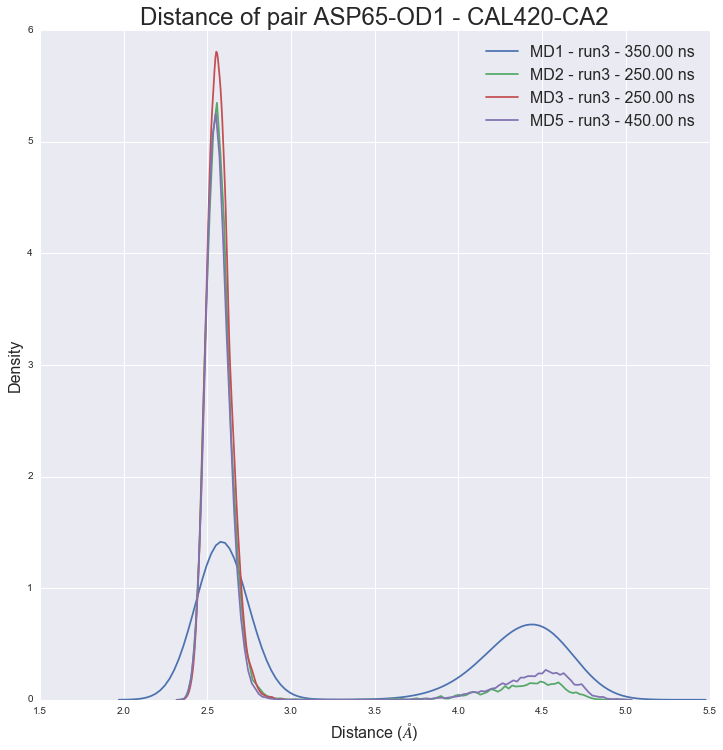

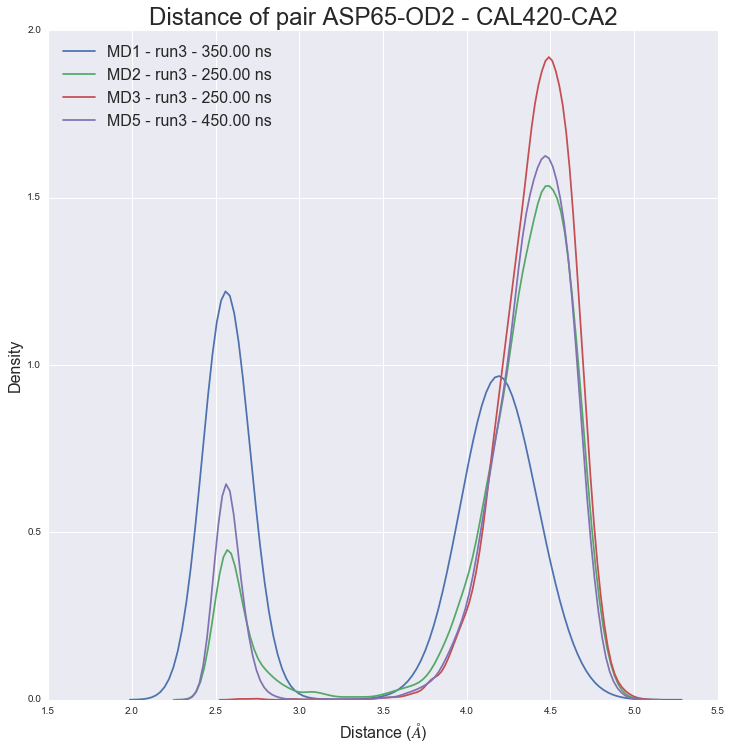

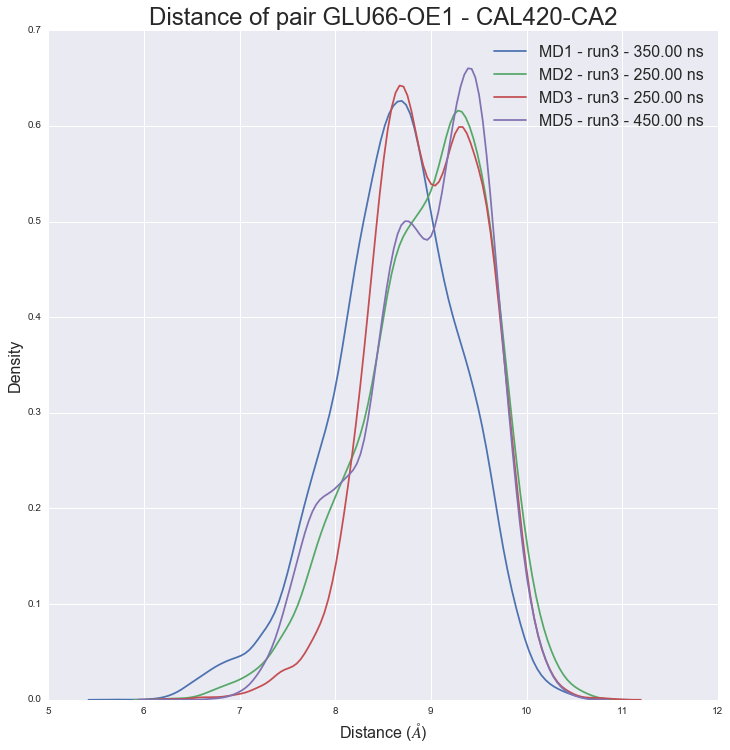

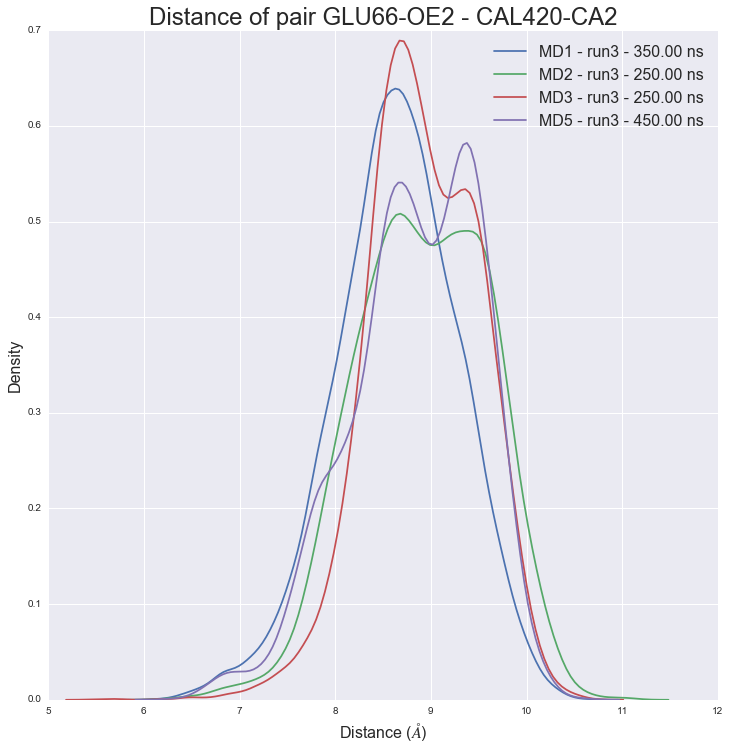

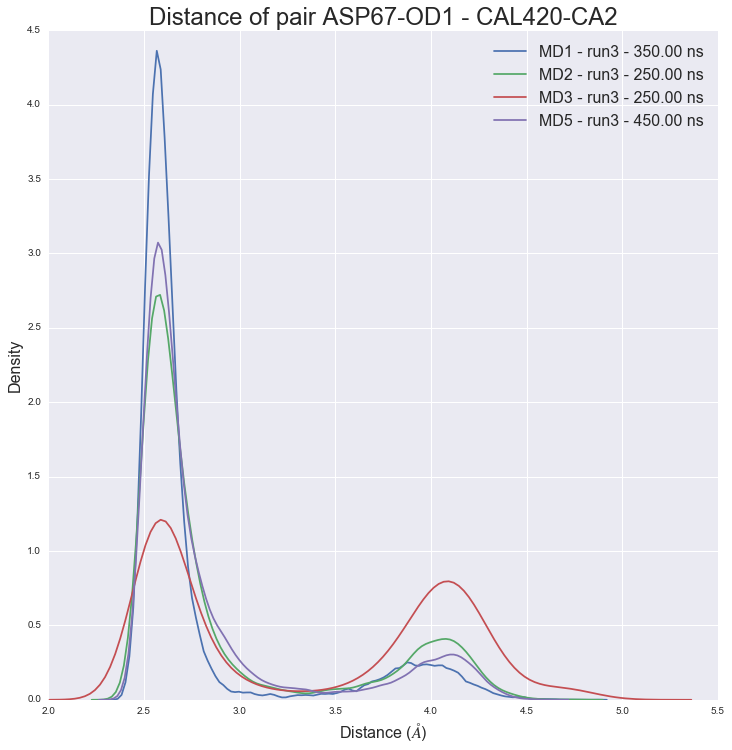

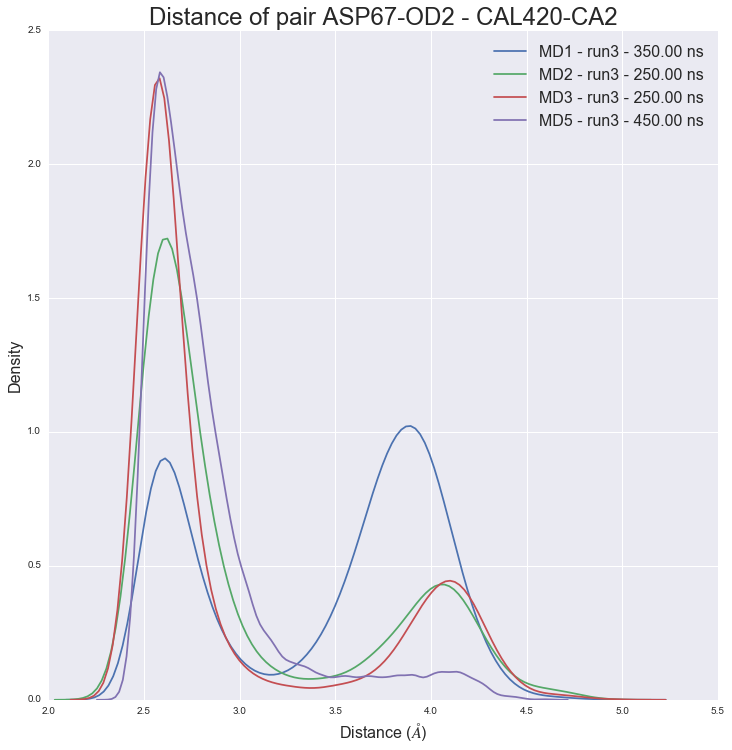

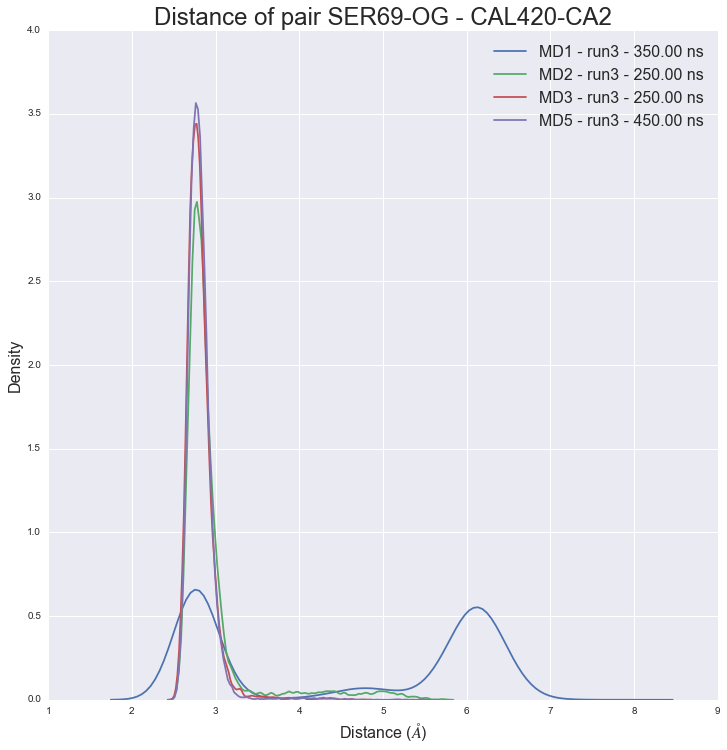

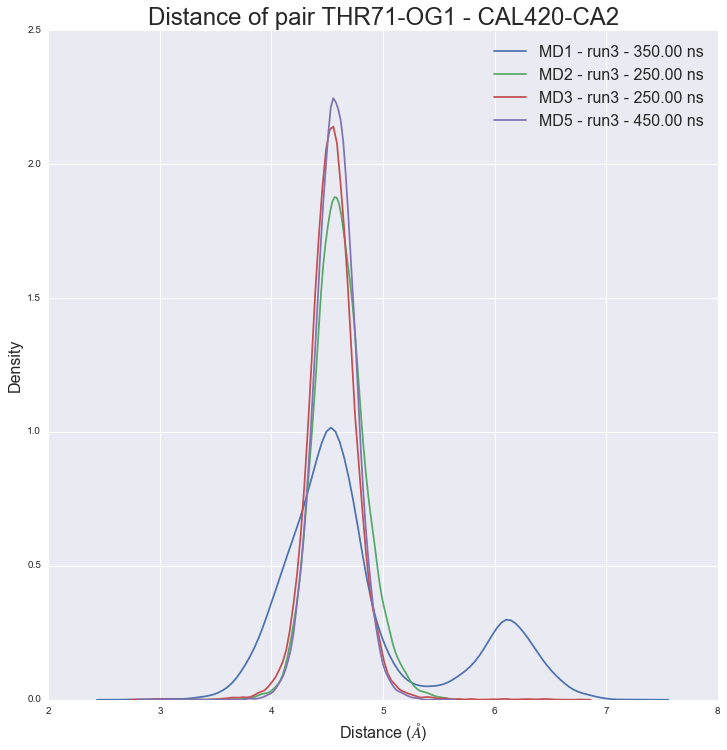

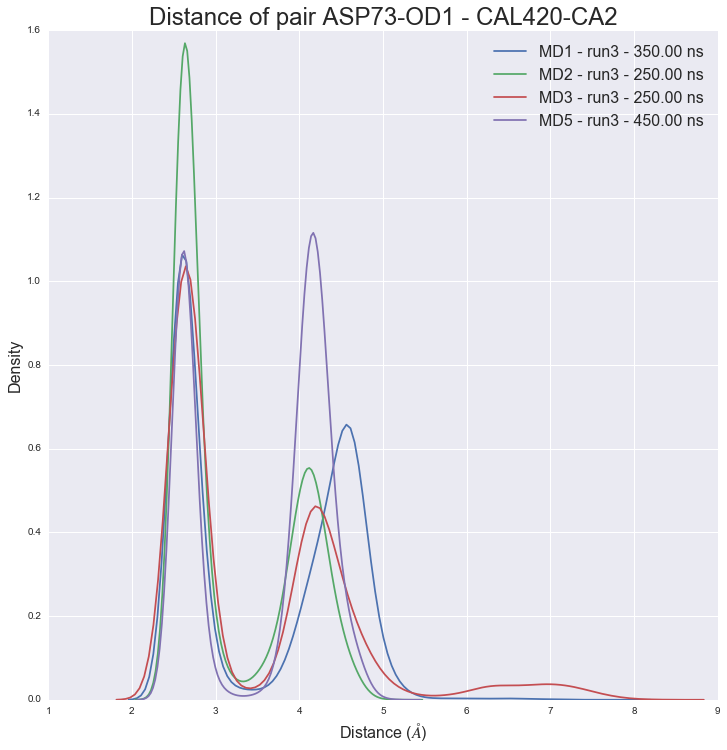

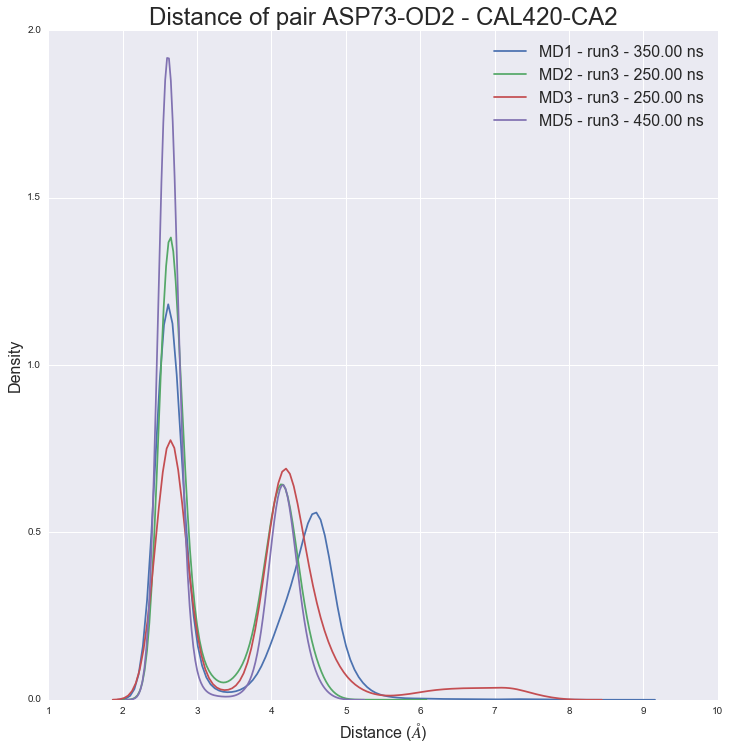

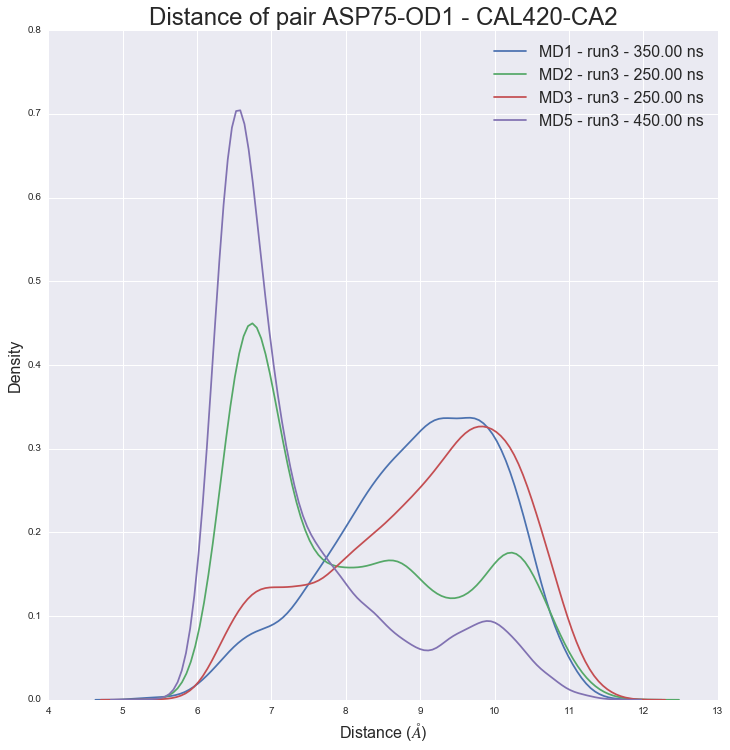

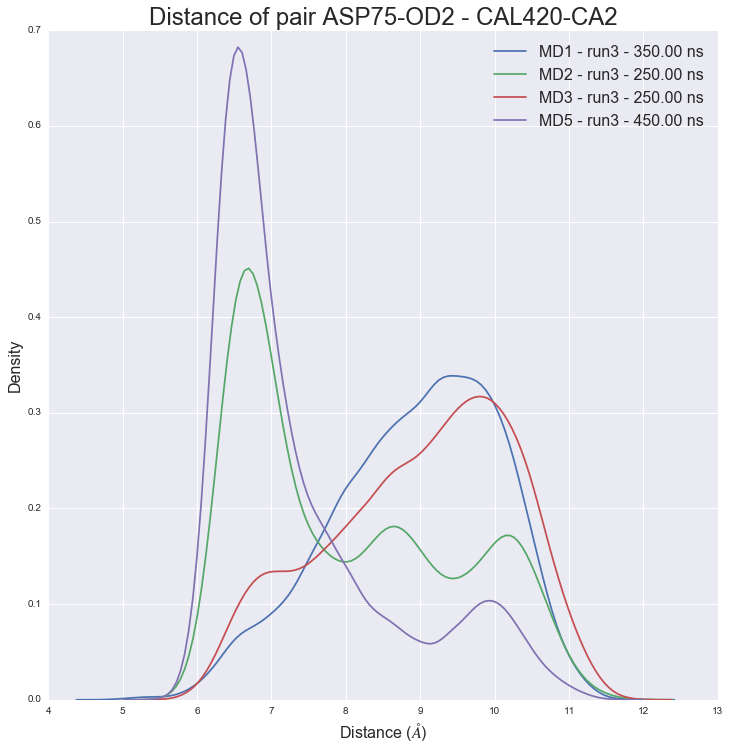

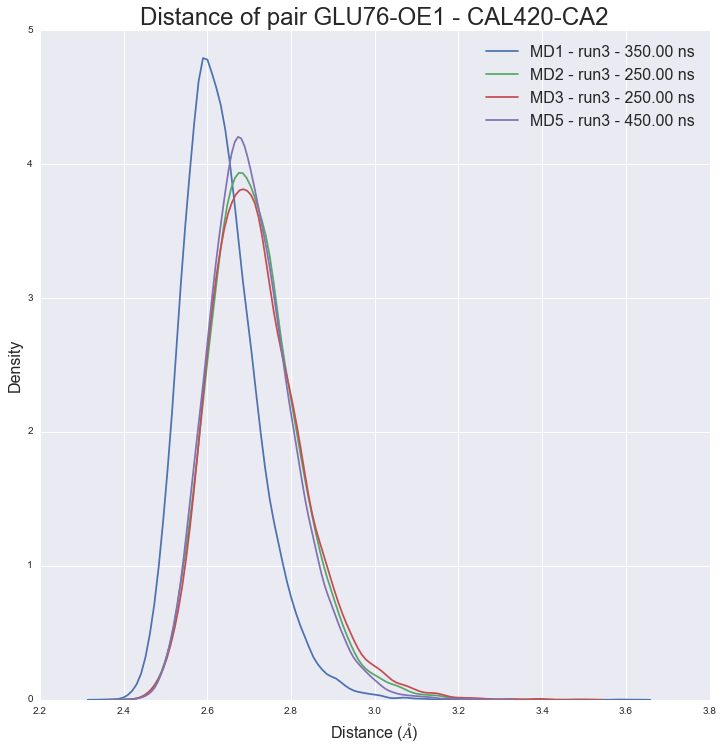

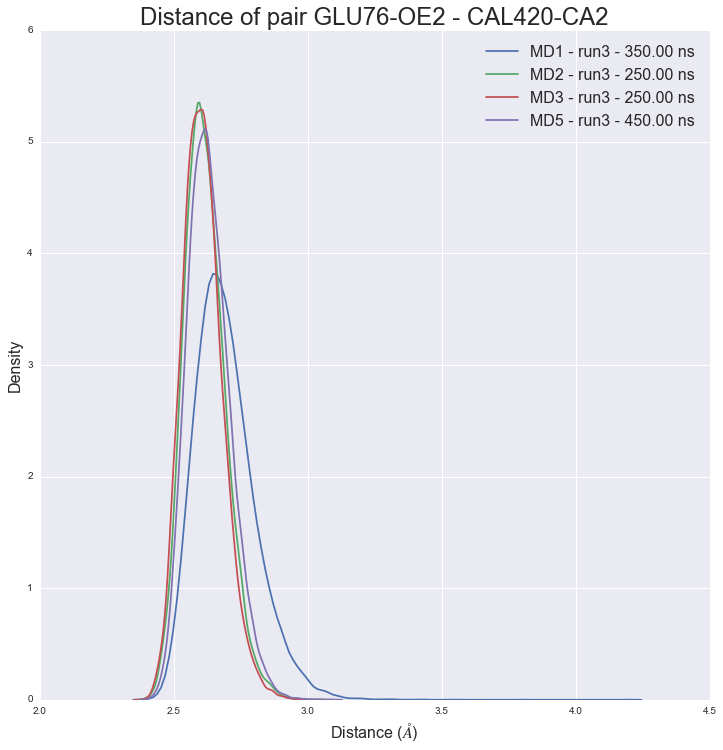

In [7]:
atom2 = 'resid 419'
for atom1 in atom1_list:
    plt.figure(figsize = (12,12)) 
    for traj_i, top_i, name in zip(traj_list, top_list, complex_names):
        distance, pair, sim_time = main(top_i, traj_i, atom1, atom2, verbose = 0, plot_dist = False)
        ax = sns.distplot(distance, hist=False, label= '%s - %.2f ns' %(name, sim_time))
    ax.set_xlabel('Distance (${\AA}$)', size = 16)
    ax.set_ylabel('Density', size = 16)
    ax.set_title('Distance of pair %s' %(pair) , size = 24)
    ax.legend(loc = 'best', prop={'size':16})
    plt.show()

## MD1

In [ ]:
topology_MD1 = '/Users/gil_f.hoben/Troponin_md_processed/MD1/run3/troponin_egcg_MD1_nowater.prmtop'
trajectory_MD1 = '/Users/gil_f.hoben/Troponin_md_processed/MD1/run3/Trajectories/'
atom1_list = ['name OD1 and resid 64', 'name OD2 and resid 64','name OE1 and resid 65', 
              'name OE2 and resid 65', 'name OD1 and resid 66',
              'name OD2 and resid 66', 'name OG and resid 68', 'name OG1 and resid 70', 
              'name OD1 and resid 72', 'name OD2 and resid 72', 'name OD1 and resid 74',
              'name OD2 and resid 74', 'name OE1 and resid 75', 'name OE2 and resid 75']
atom2 = 'resid 419'

In [ ]:
for atom1 in atom1_list:
    main(topology_MD1, trajectory_MD1, atom1, atom2, verbose = 1)

## MD2

In [ ]:
topology_MD2 = '/Users/gil_f.hoben/Troponin_md_processed/MD2/run3/troponin_egcg_MD2_nowater.prmtop'
trajectory_MD2 = '/Users/gil_f.hoben/Troponin_md_processed/MD2/run3/Trajectories/'
atom1_list = ['name OD1 and resid 64', 'name OD2 and resid 64','name OE1 and resid 65', 
              'name OE2 and resid 65', 'name OD1 and resid 66',
              'name OD2 and resid 66', 'name OG and resid 68', 'name OG1 and resid 70', 
              'name OD1 and resid 72', 'name OD2 and resid 72', 'name OD1 and resid 74',
              'name OD2 and resid 74', 'name OE1 and resid 75', 'name OE2 and resid 75']
atom2 = 'resid 419'

In [ ]:
for atom1 in atom1_list:
    main(topology_MD2, trajectory_MD2, atom1, atom2, verbose = 1)

## MD3

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP65-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


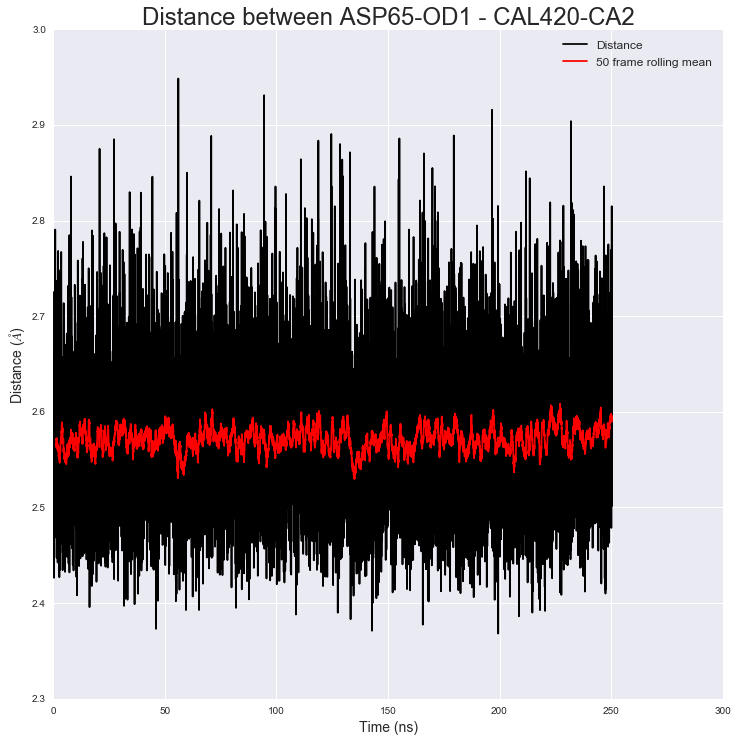

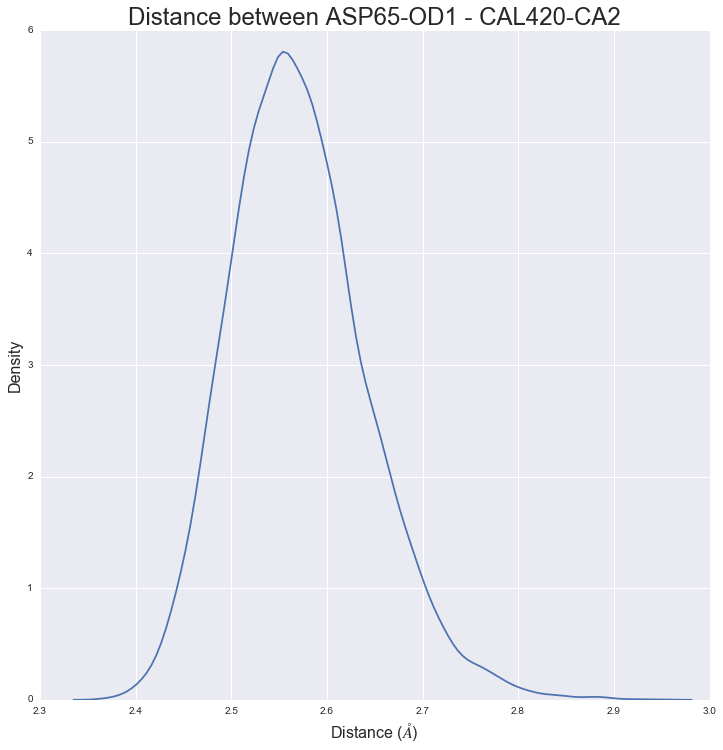

Total execution time: 8.34 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP65-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


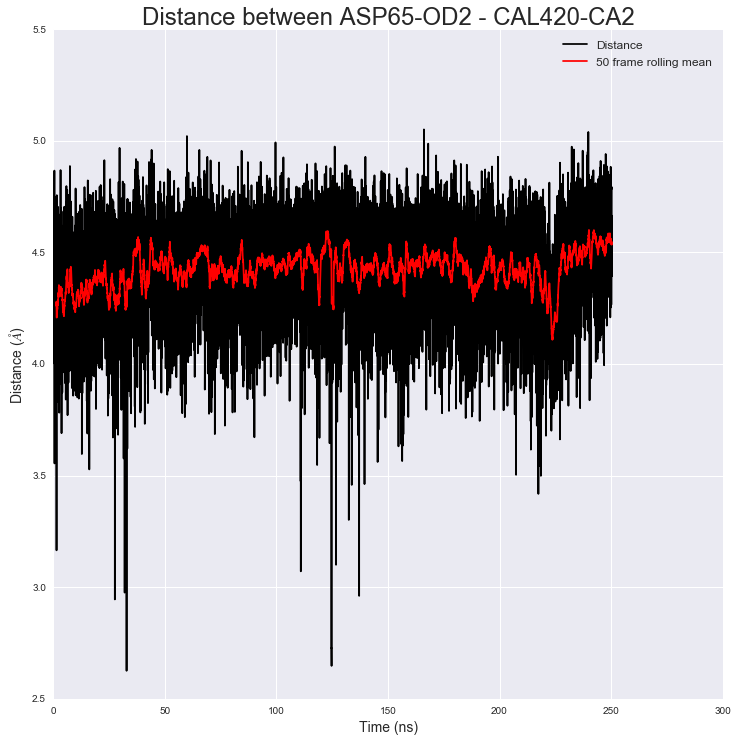

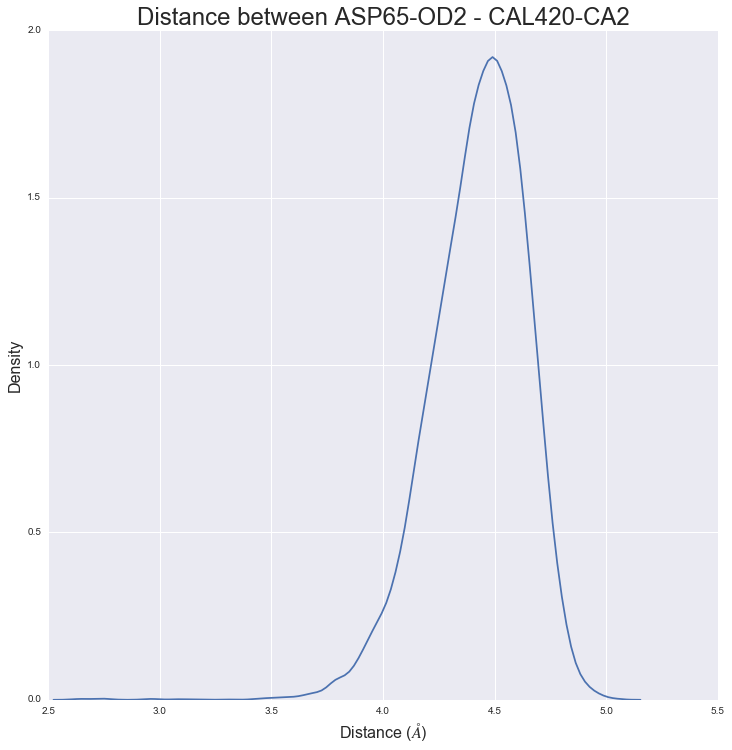

Total execution time: 8.17 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU66-OE1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


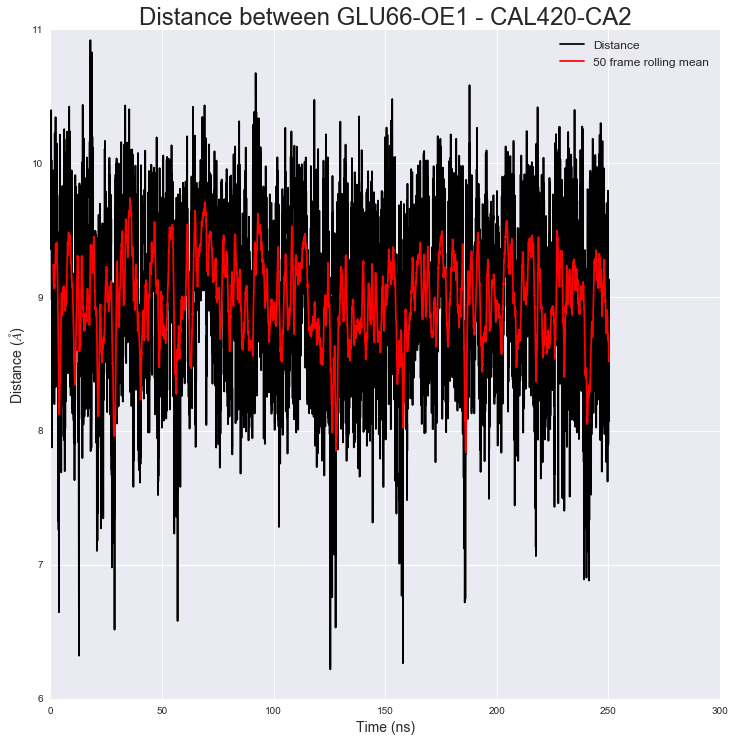

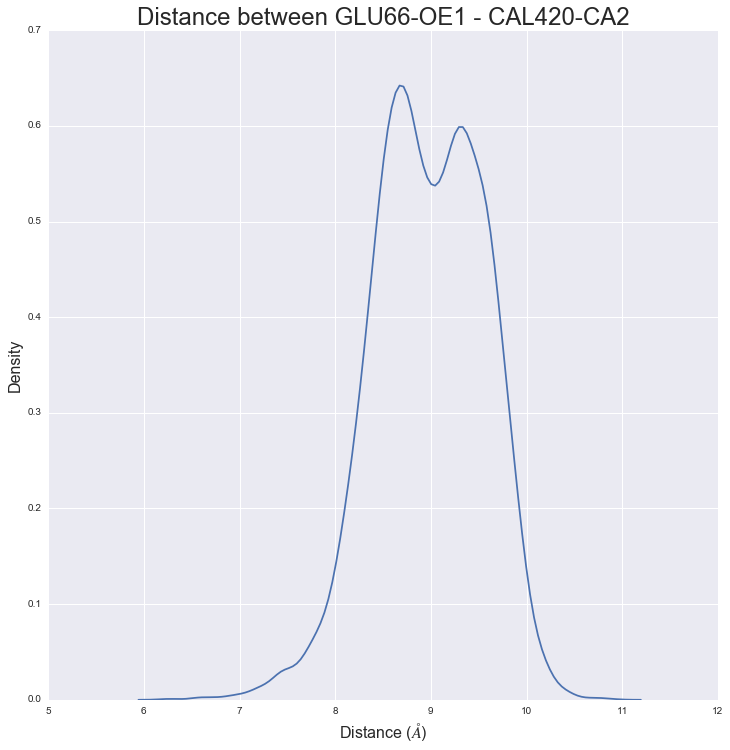

Total execution time: 9.24 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU66-OE2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


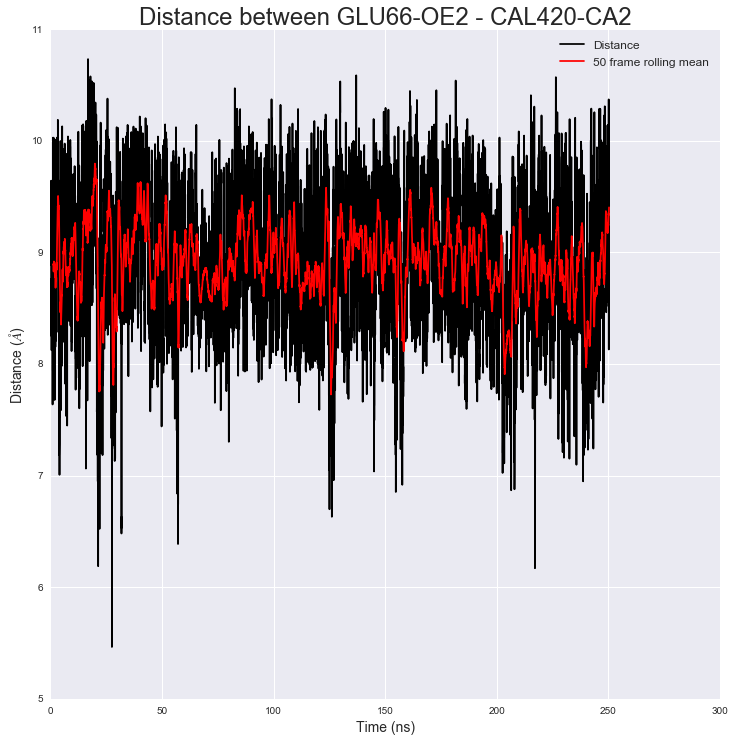

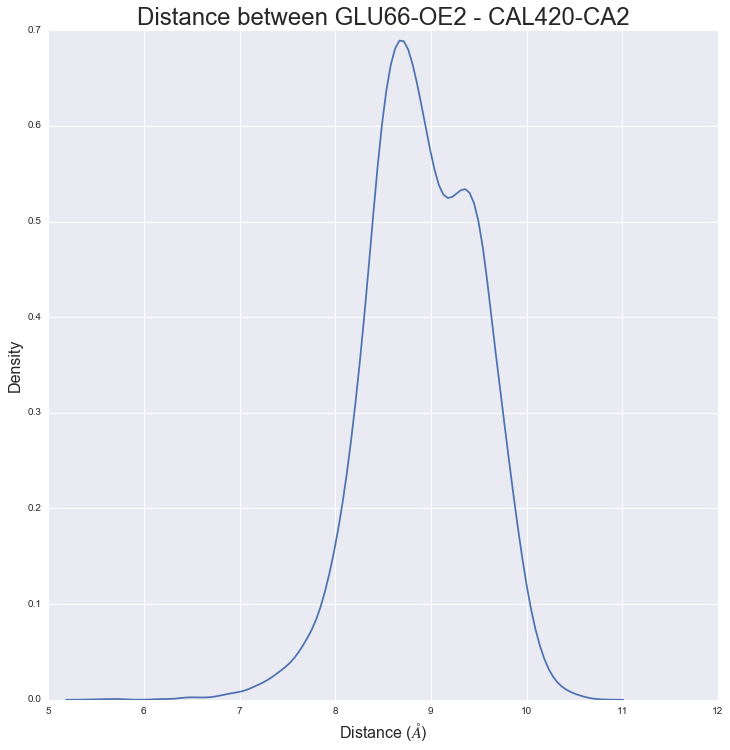

Total execution time: 7.72 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP67-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


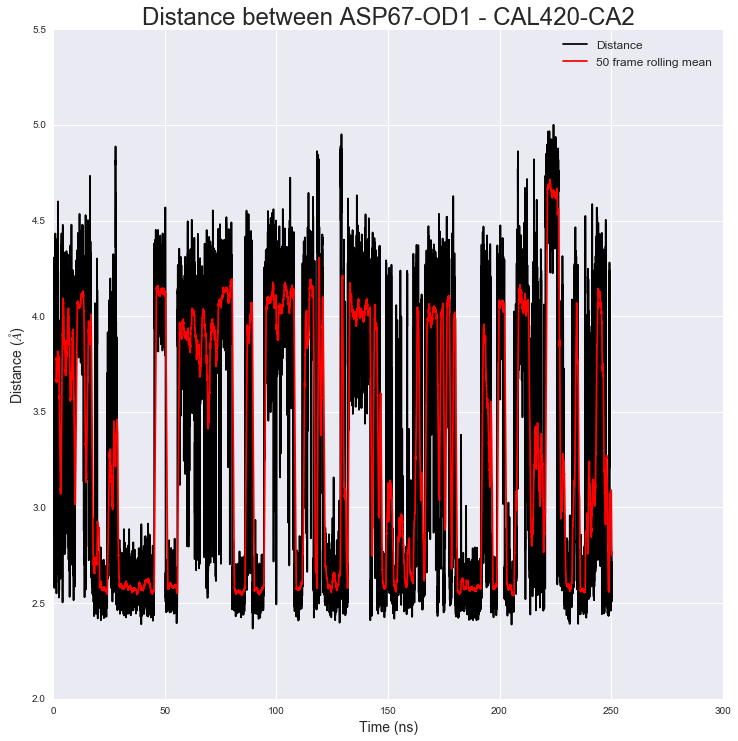

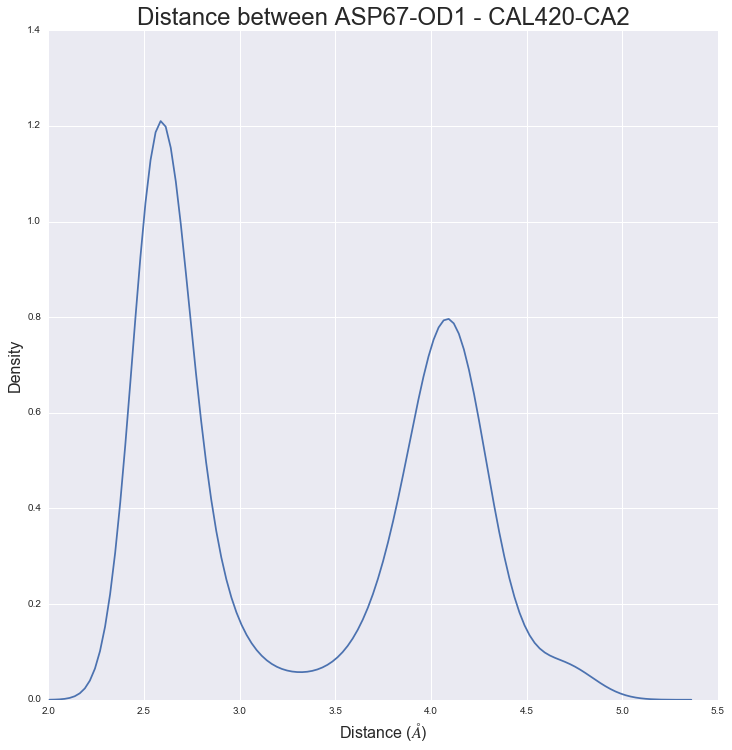

Total execution time: 7.39 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP67-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


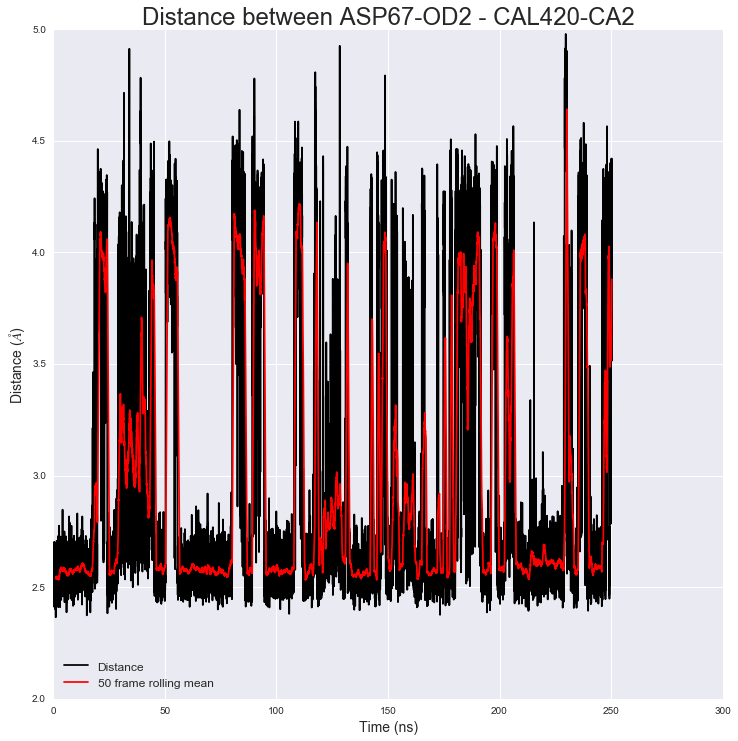

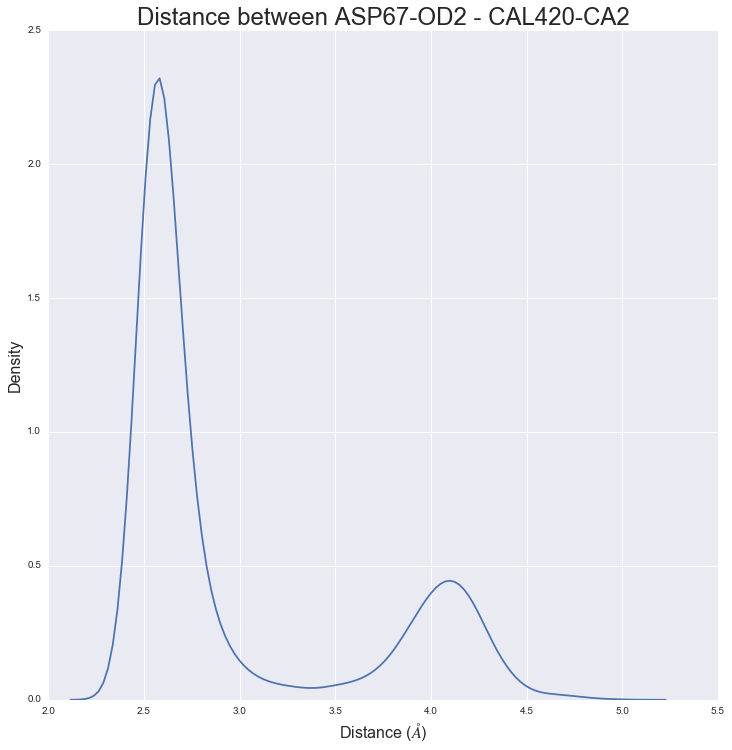

Total execution time: 7.09 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: SER69-OG - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


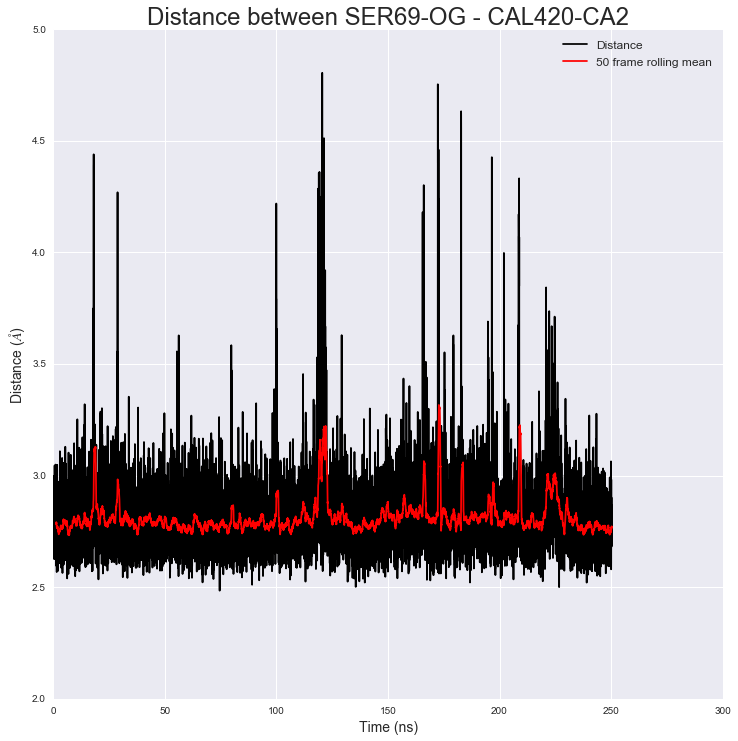

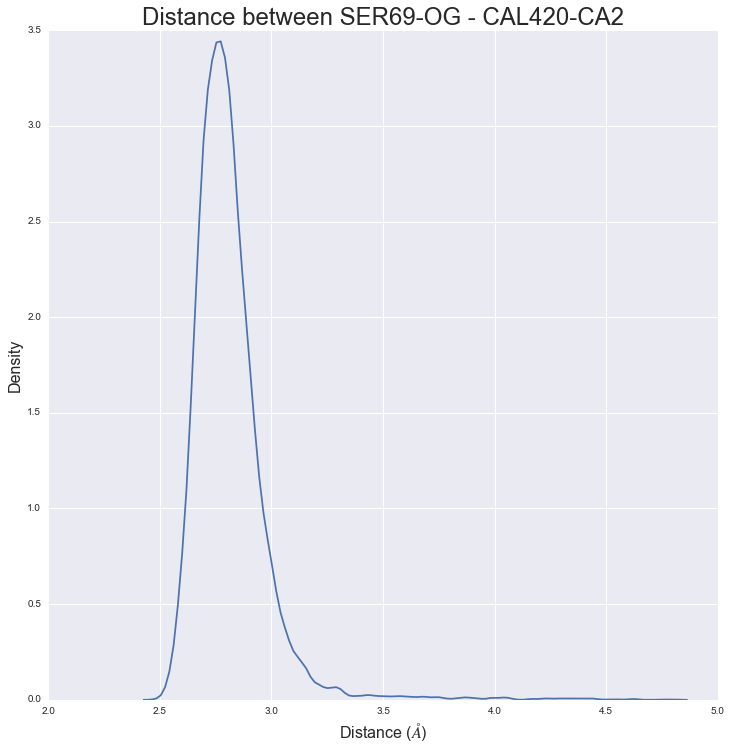

Total execution time: 6.57 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: THR71-OG1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


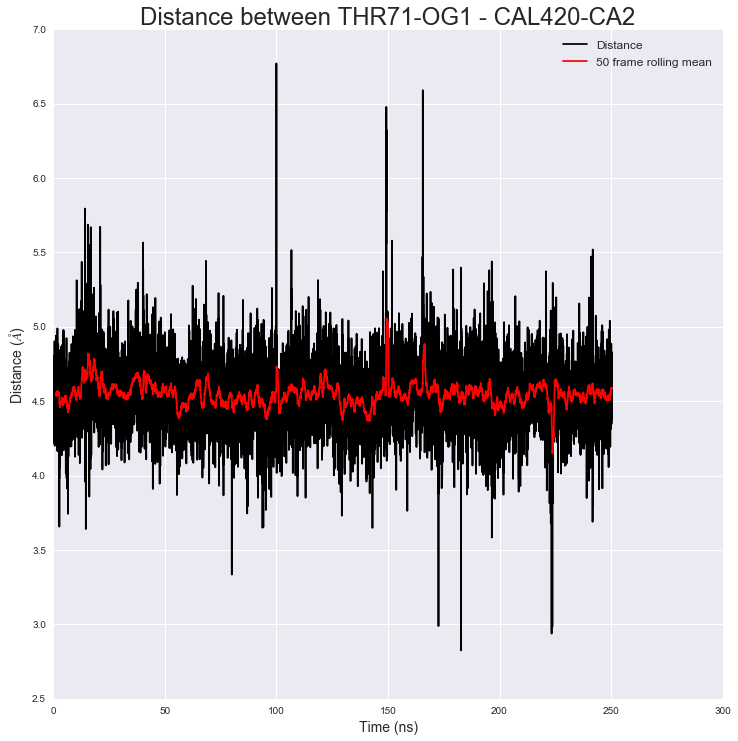

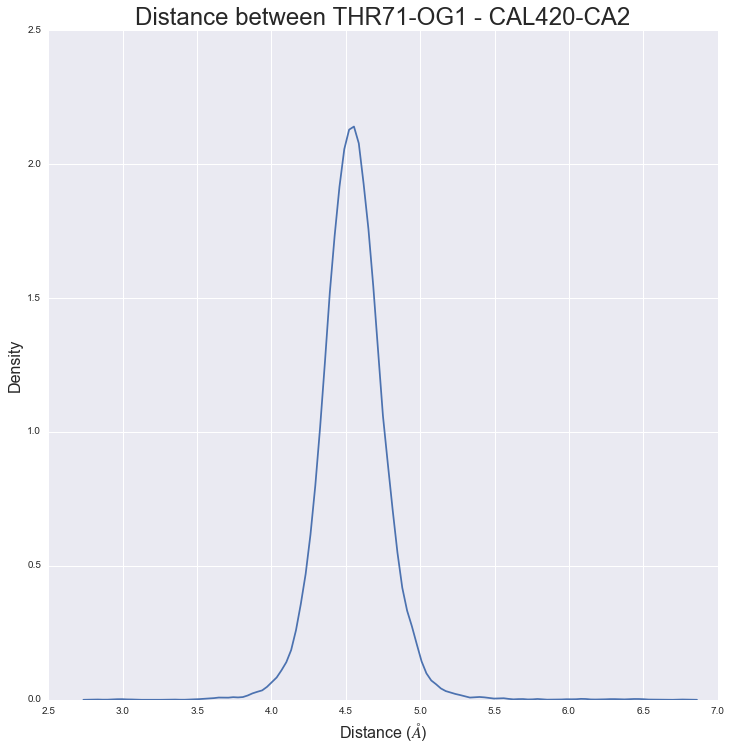

Total execution time: 5.99 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP73-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


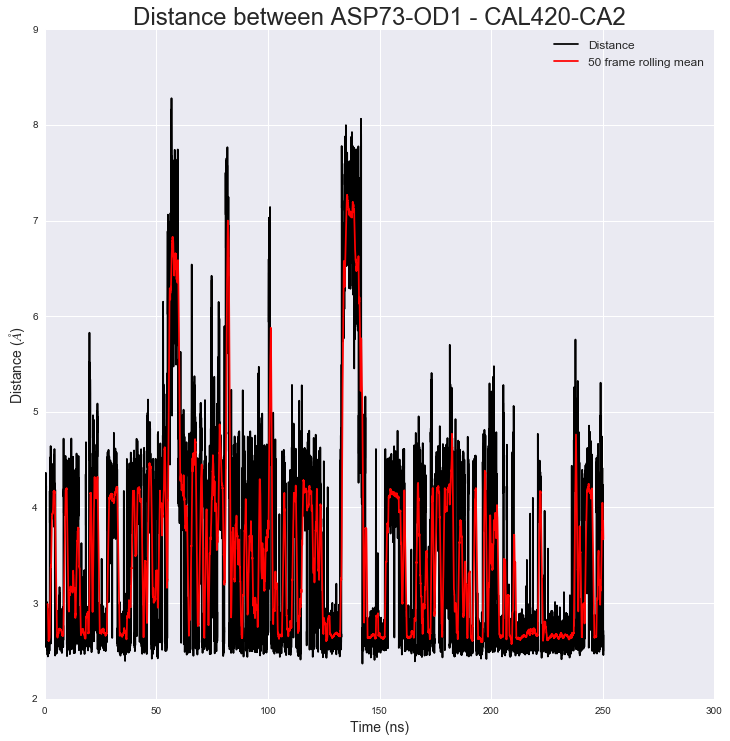

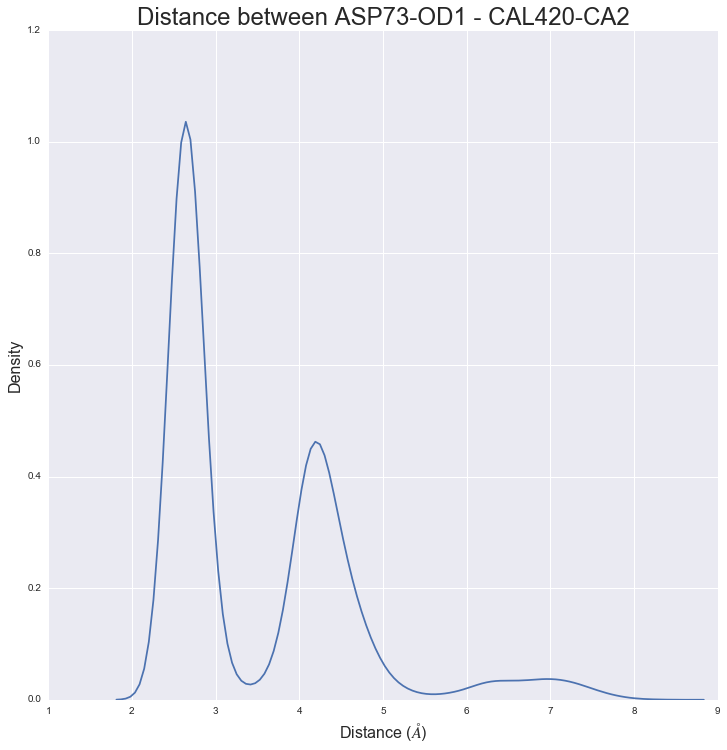

Total execution time: 7.01 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP73-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


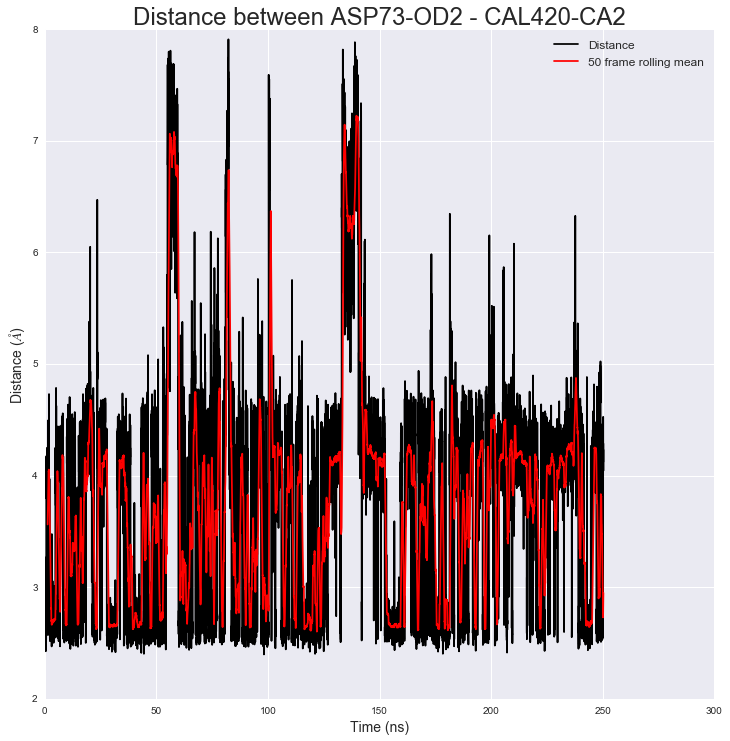

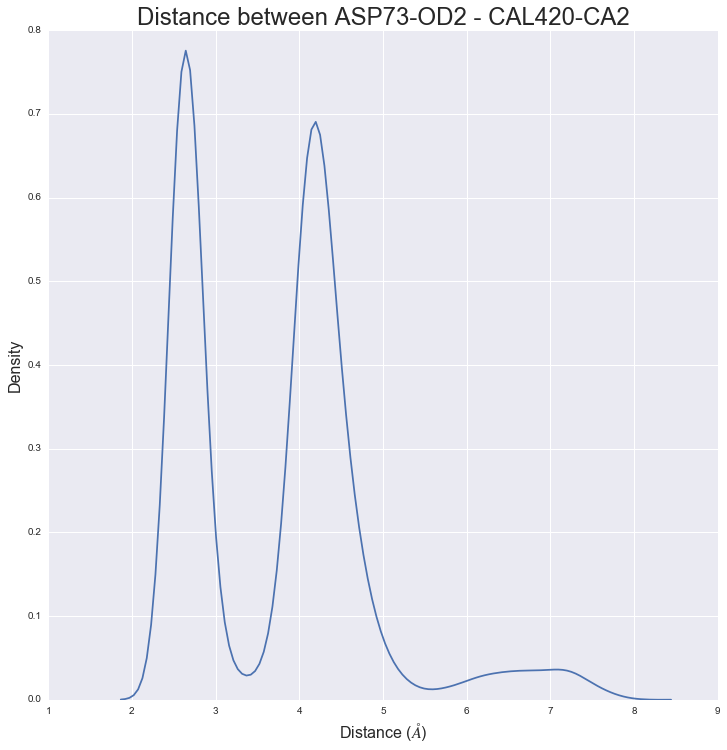

Total execution time: 7.45 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP75-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


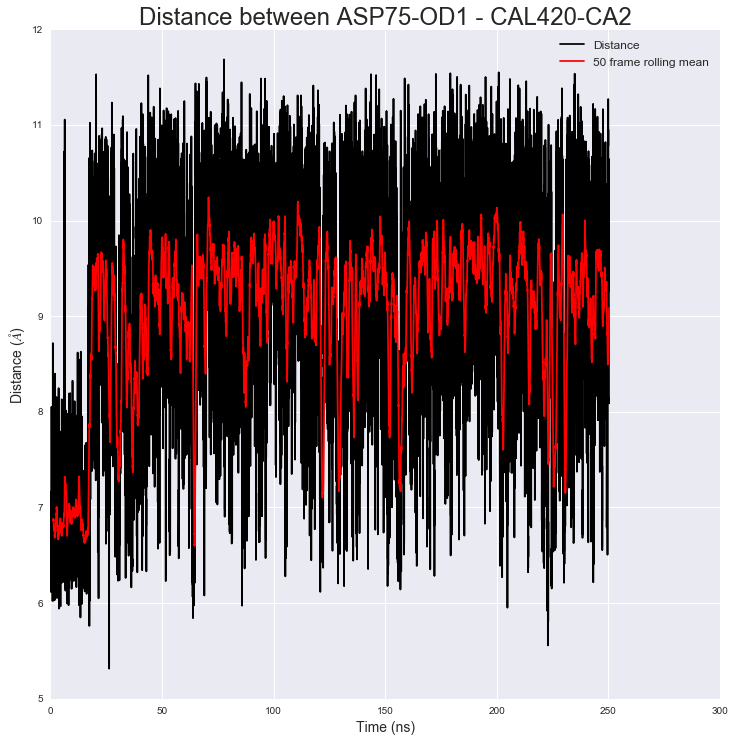

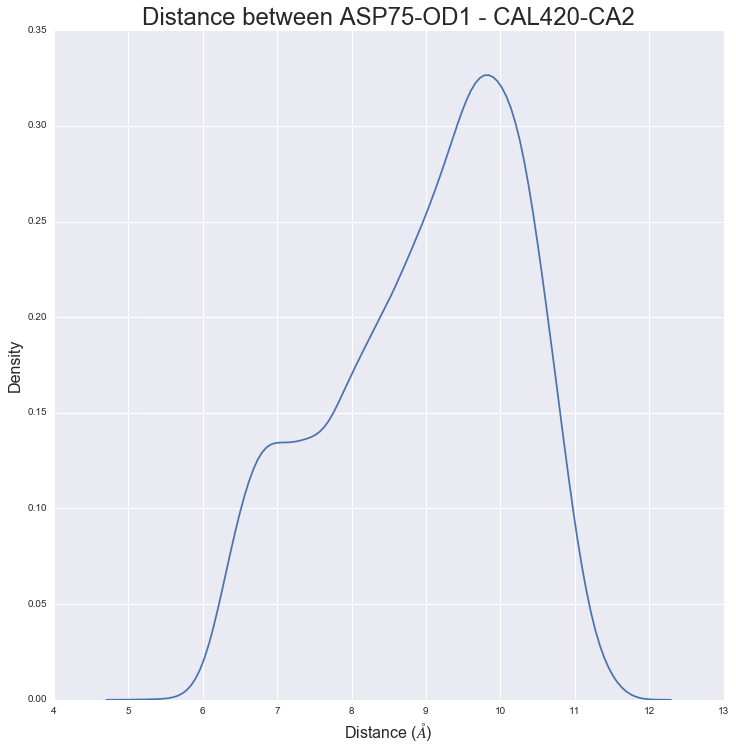

Total execution time: 7.33 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP75-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


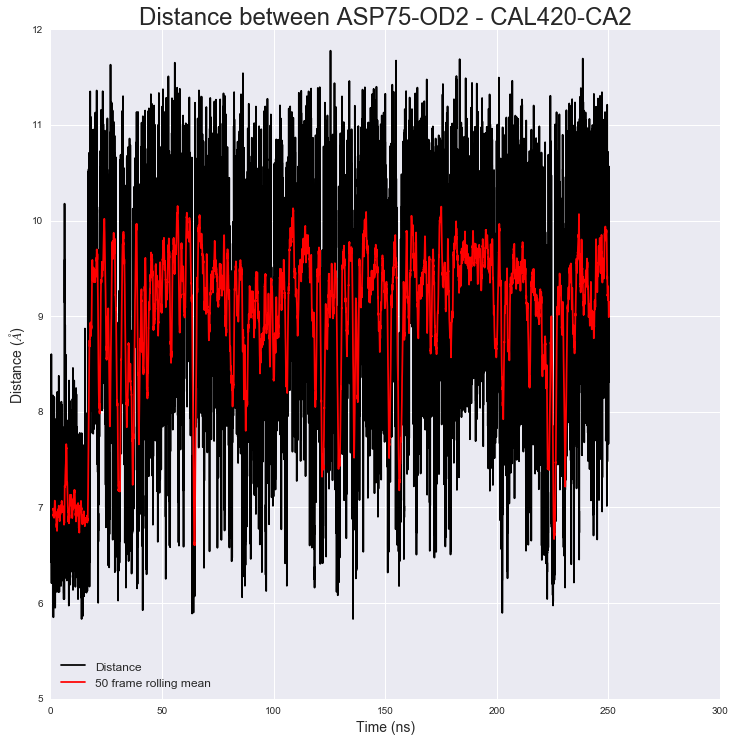

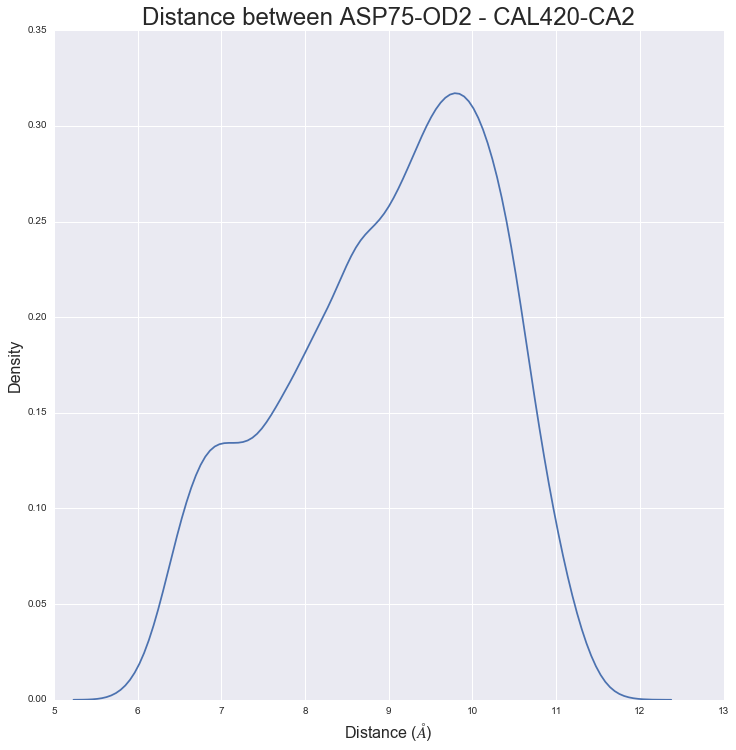

Total execution time: 6.96 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU76-OE1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


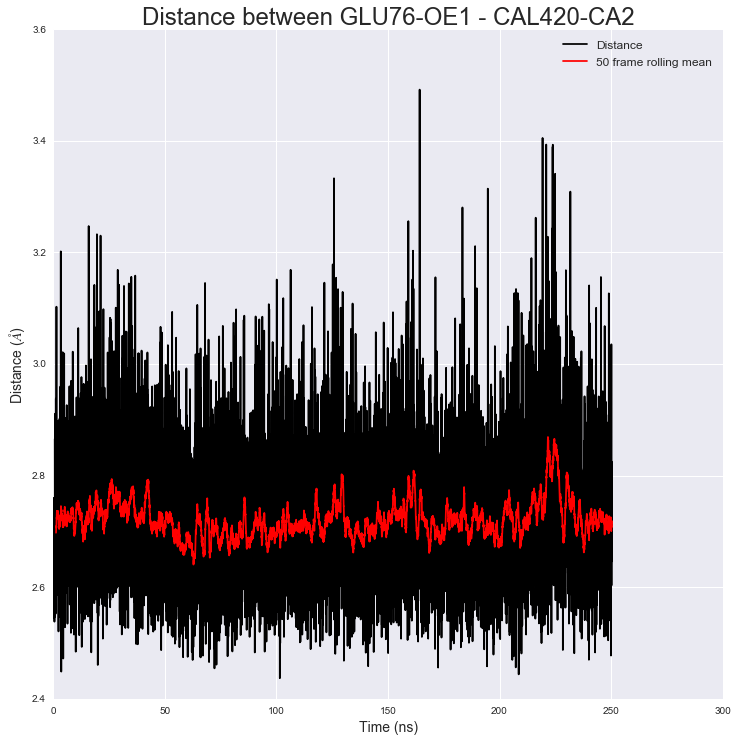

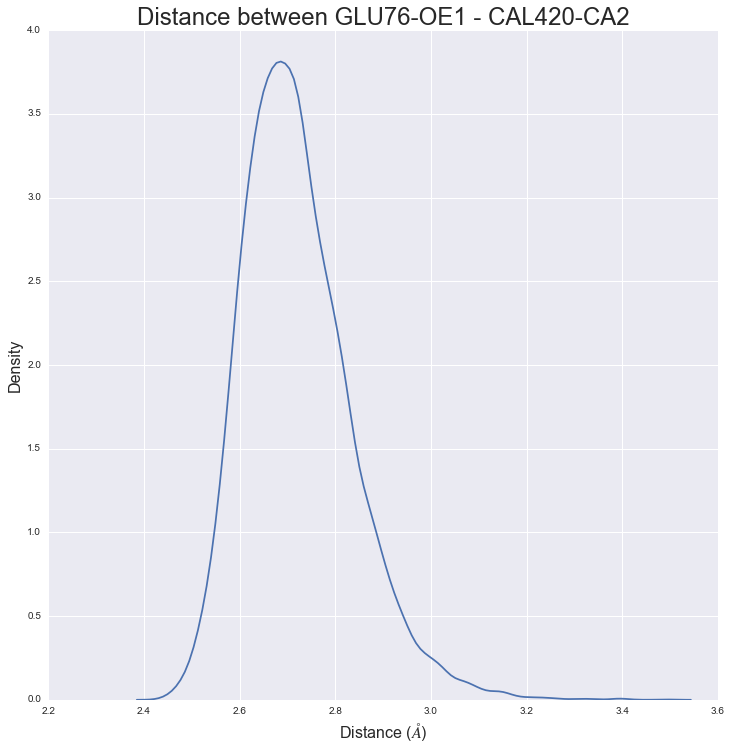

Total execution time: 7.38 seconds 

Total simulation time of all frames: 250.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU76-OE2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD3_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD3_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD3_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD3_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD3_200-250_run3_nowater.nc


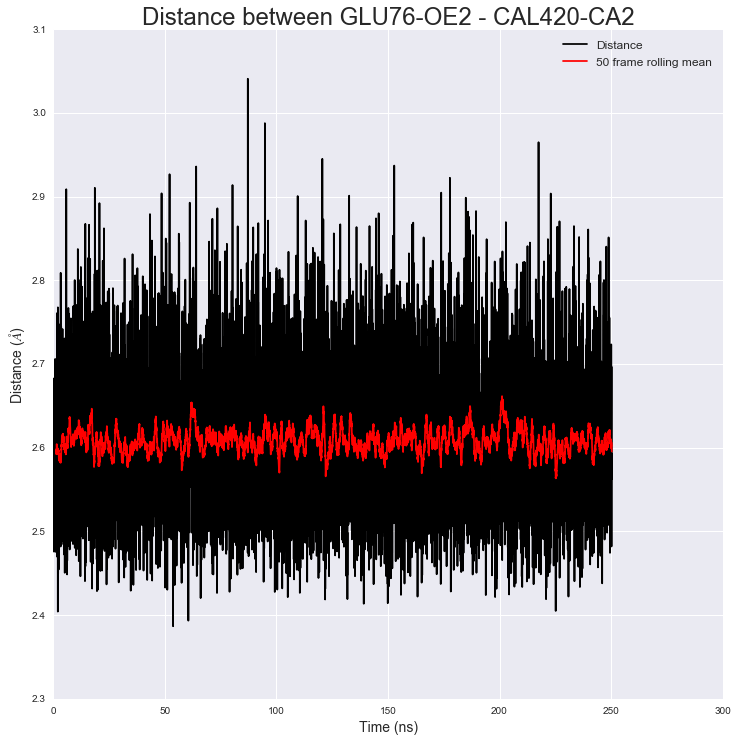

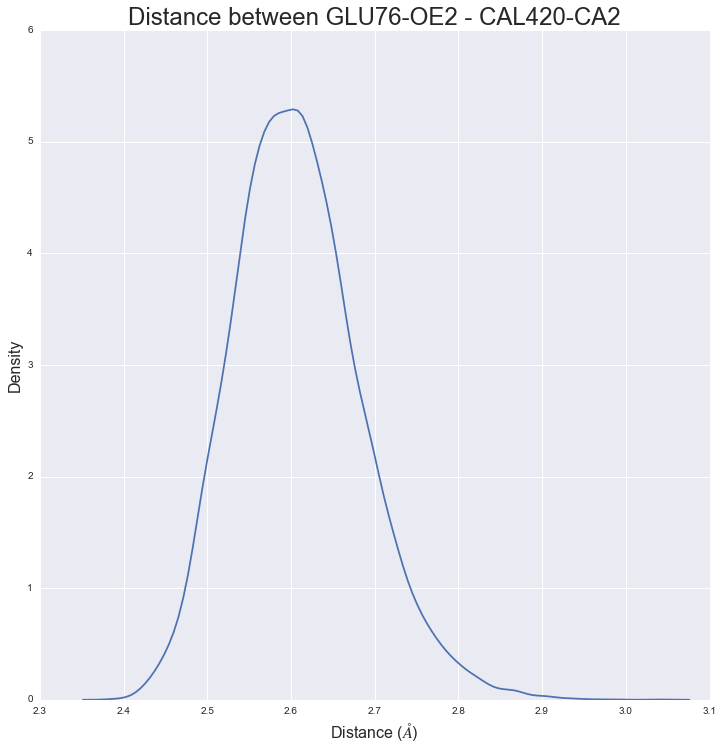

Total execution time: 7.68 seconds 

Total simulation time of all frames: 250.00 nanoseconds


In [8]:
topology_MD3 = '/Users/gil_f.hoben/Troponin_md_processed/MD3/run3/troponin_egcg_MD3_nowater.prmtop'
trajectory_MD3 = '/Users/gil_f.hoben/Troponin_md_processed/MD3/run3/Trajectories/'
for atom1 in atom1_list:
    main(topology_MD3, trajectory_MD3, atom1, atom2, verbose = 1)

## MD5

The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP65-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


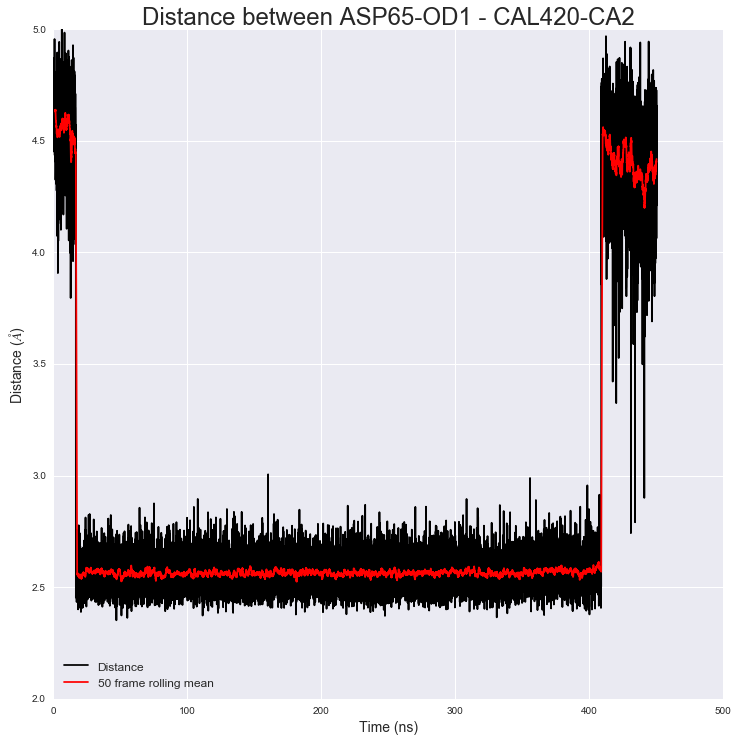

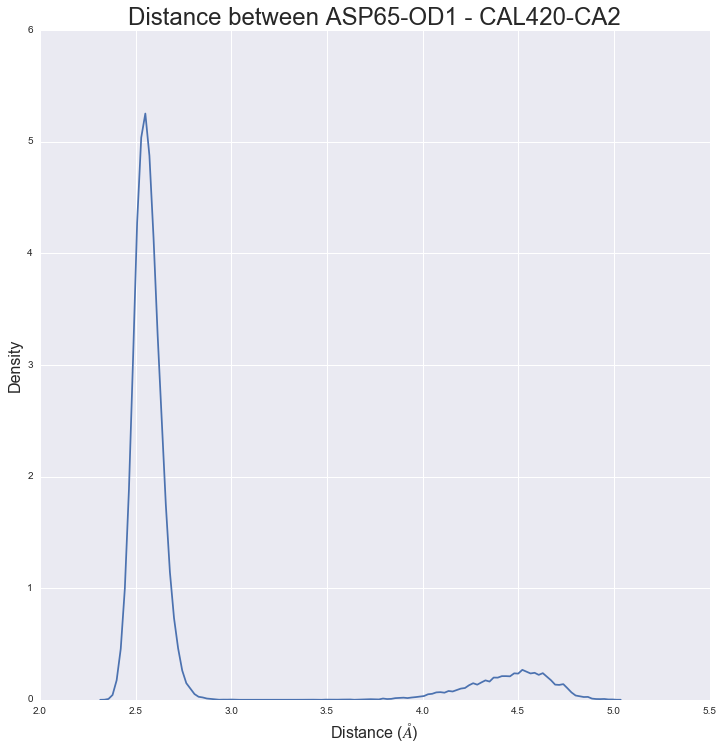

Total execution time: 10.47 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP65-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


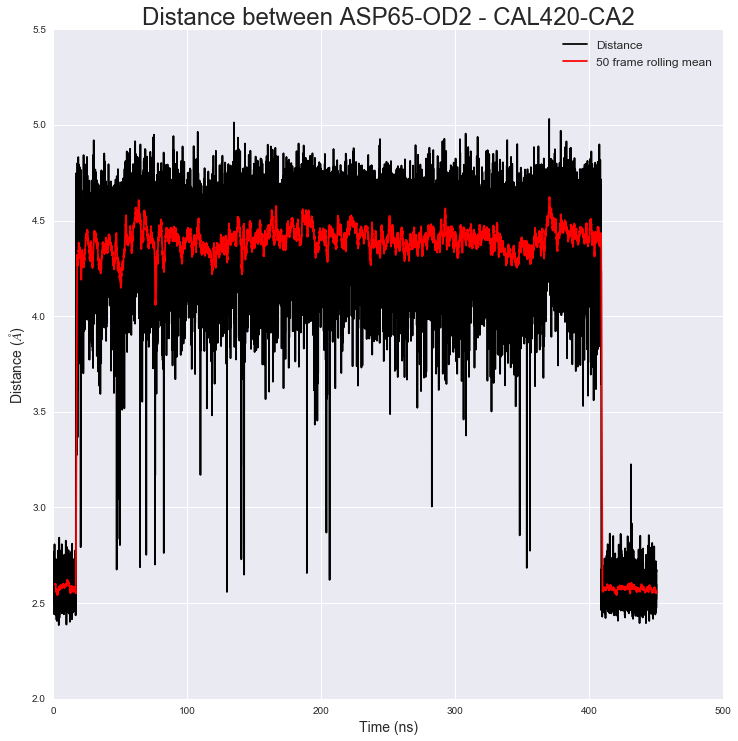

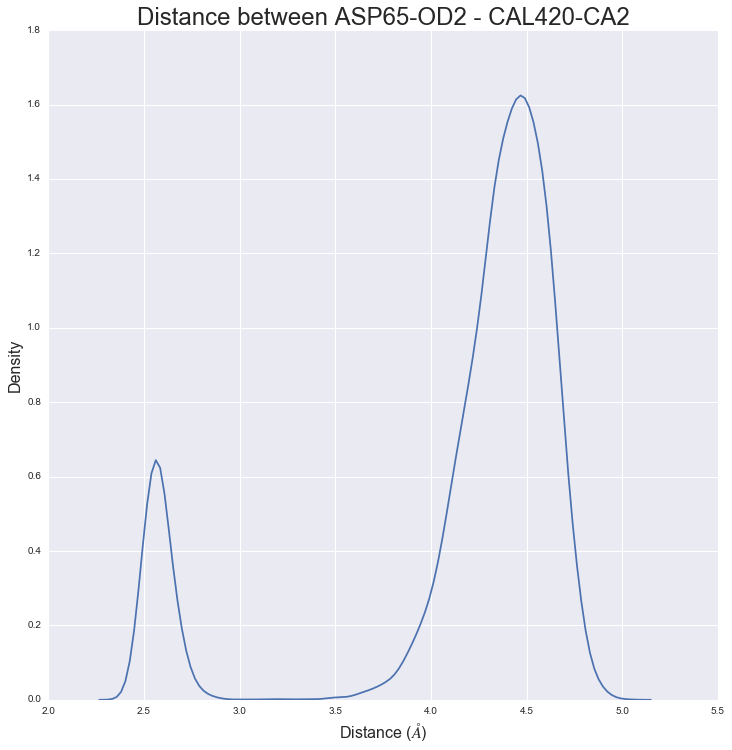

Total execution time: 9.70 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU66-OE1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


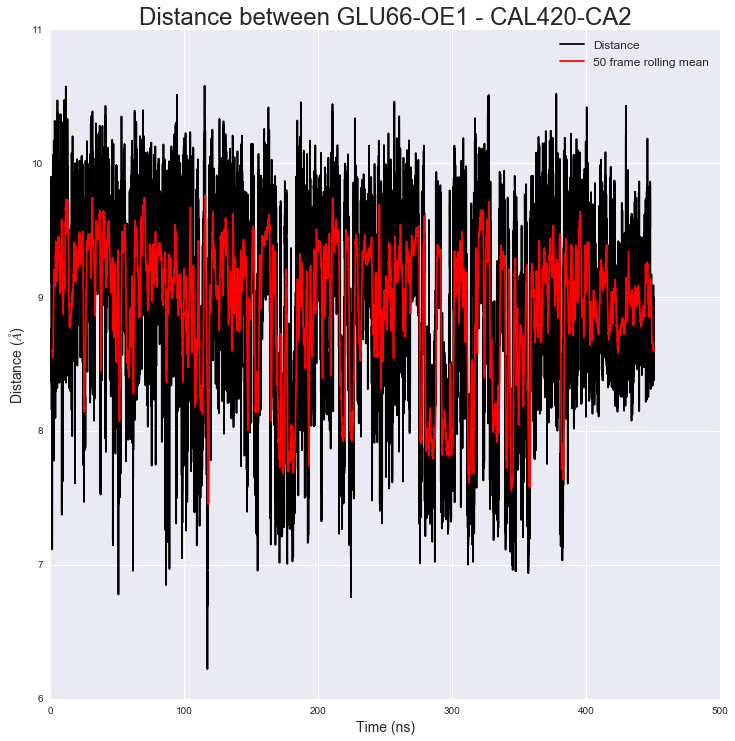

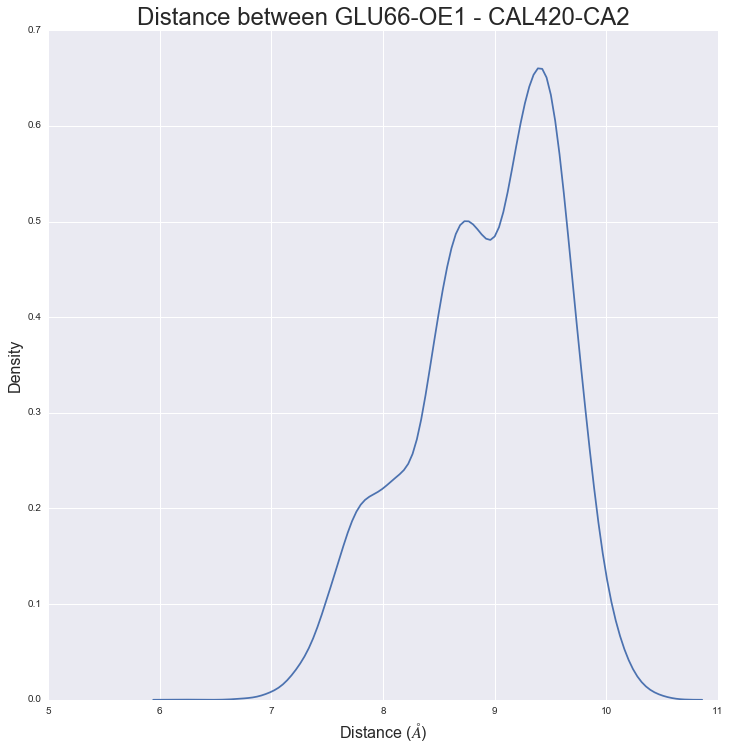

Total execution time: 8.47 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU66-OE2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


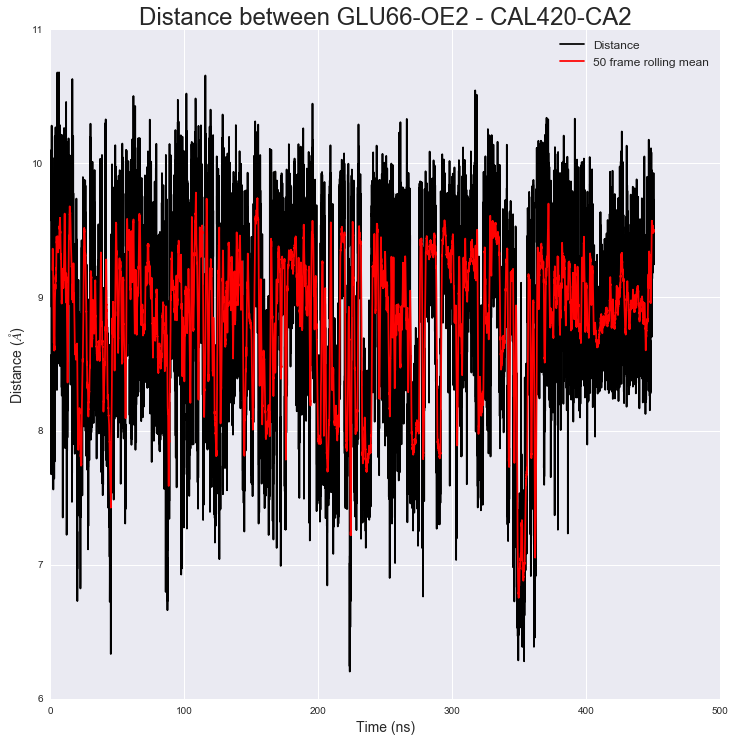

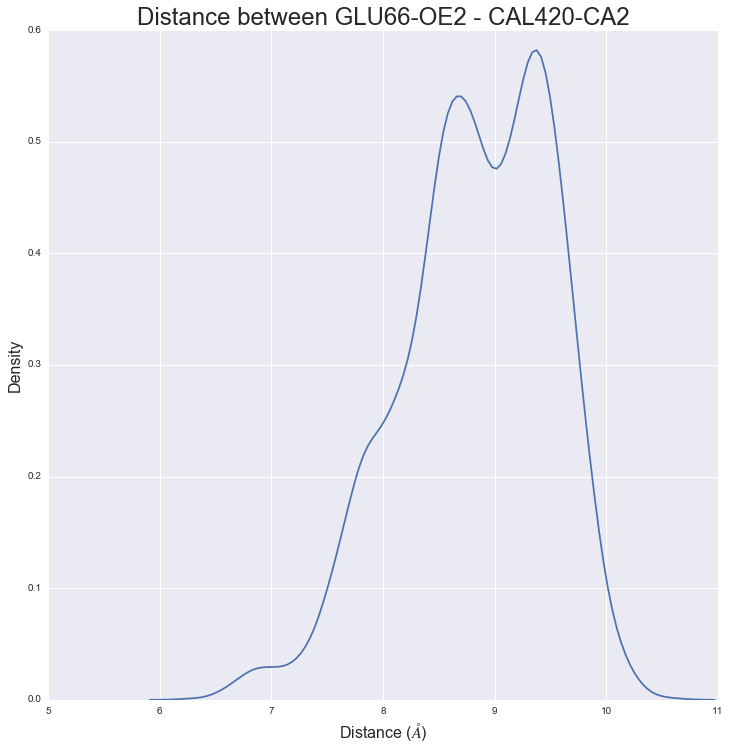

Total execution time: 8.13 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP67-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


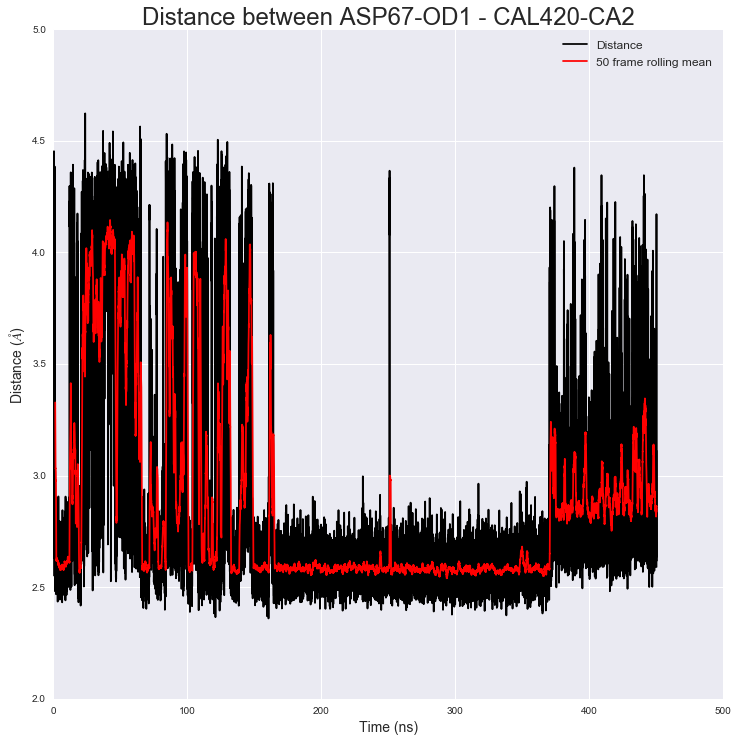

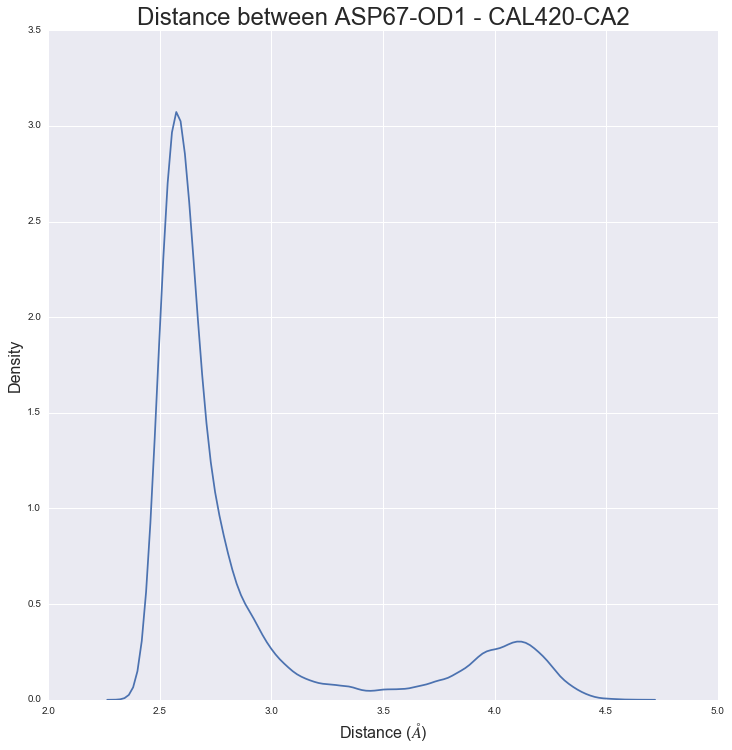

Total execution time: 8.06 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP67-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


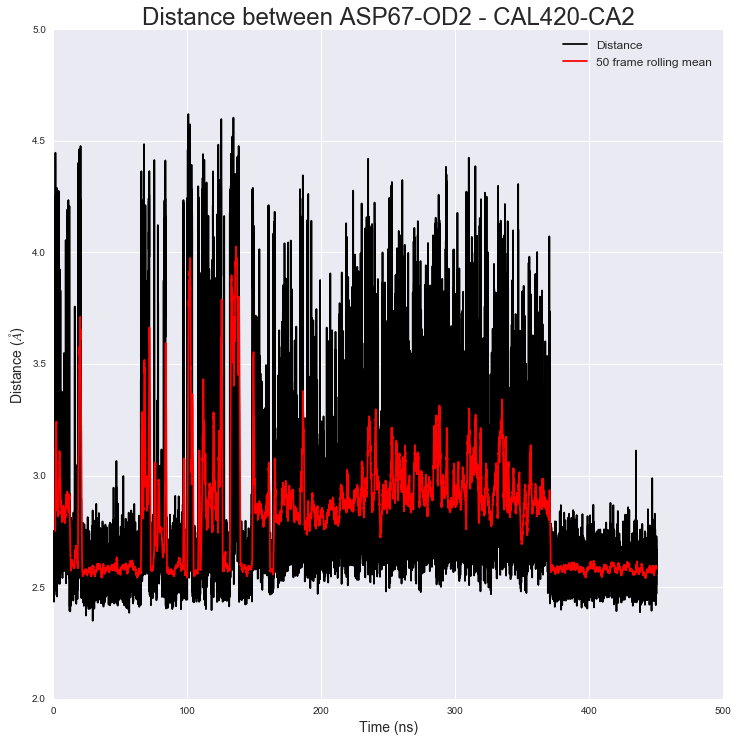

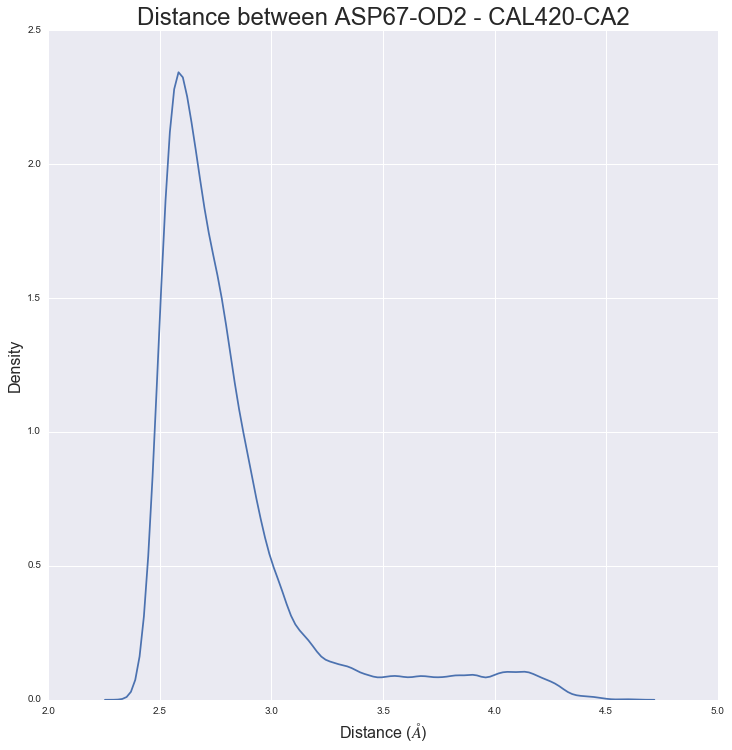

Total execution time: 8.65 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: SER69-OG - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


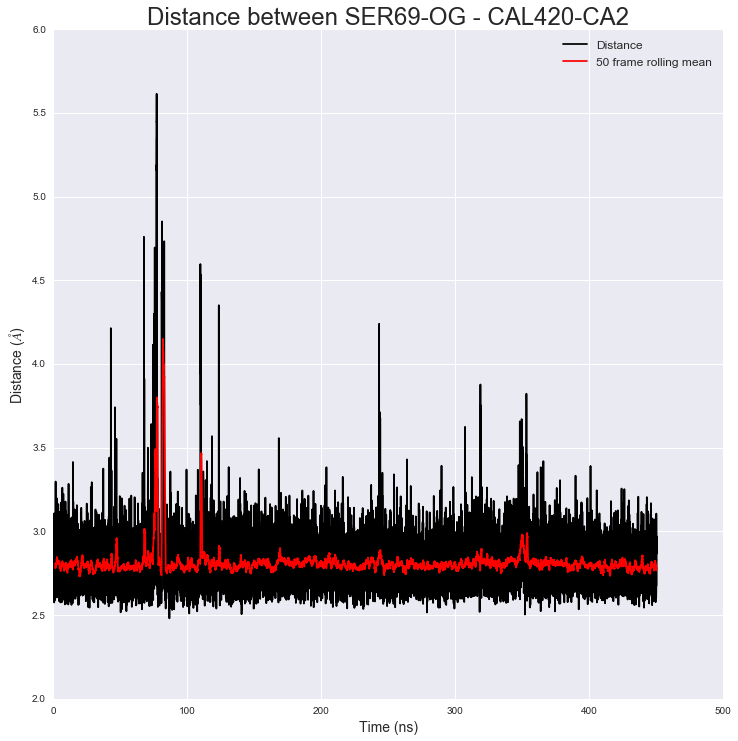

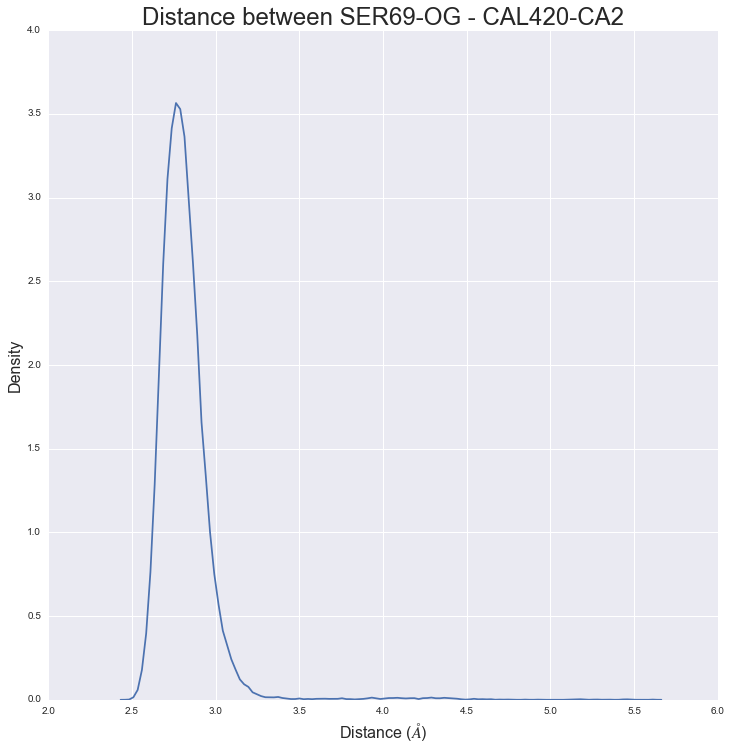

Total execution time: 8.14 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: THR71-OG1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


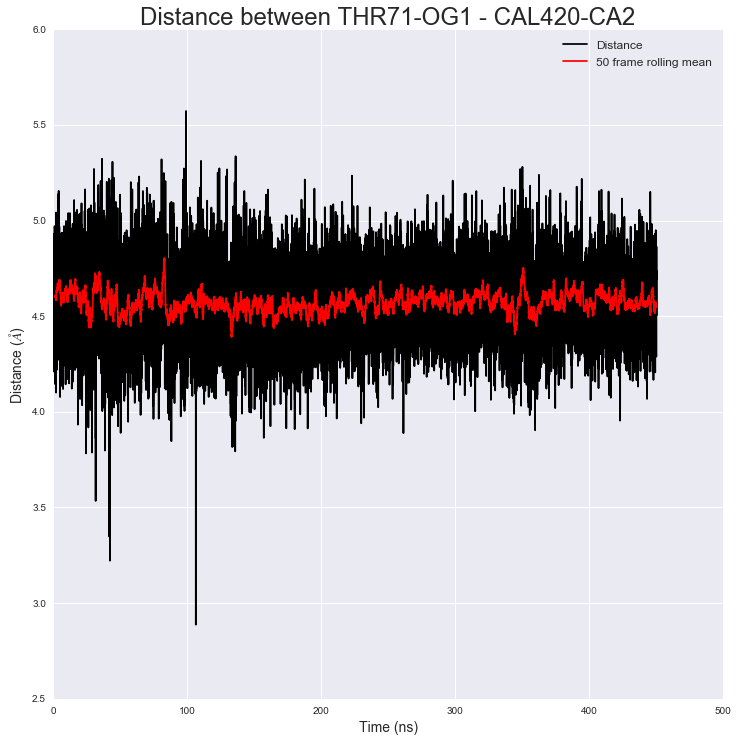

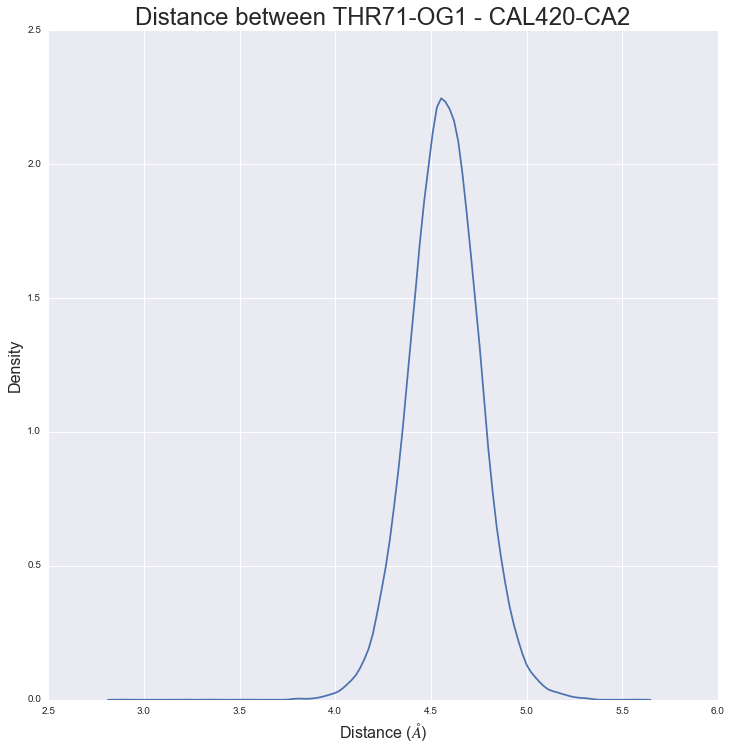

Total execution time: 8.26 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP73-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


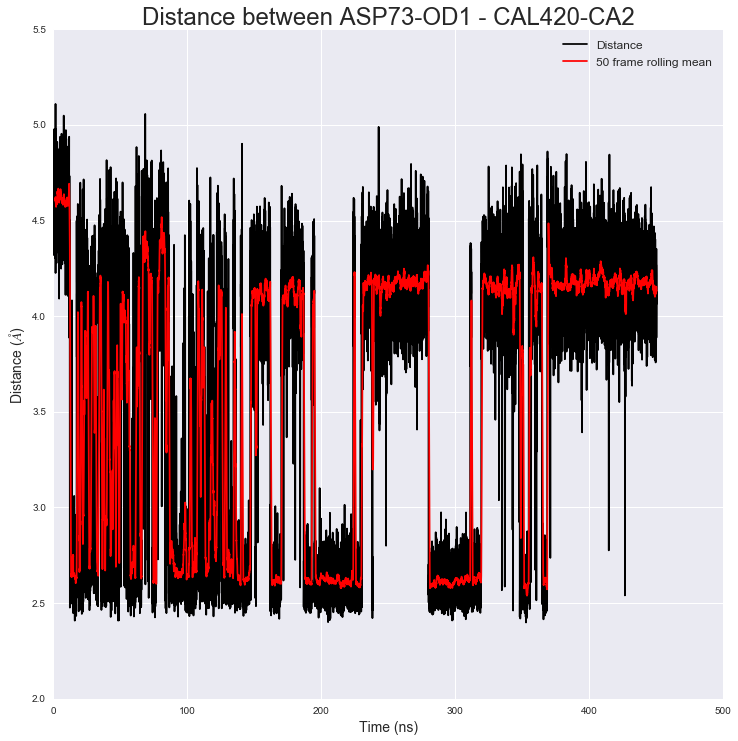

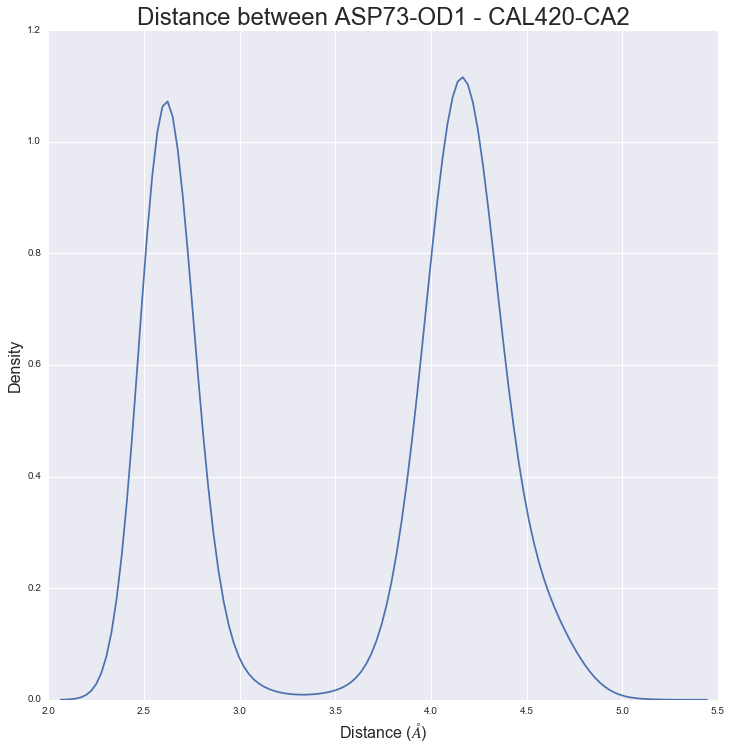

Total execution time: 8.02 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP73-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


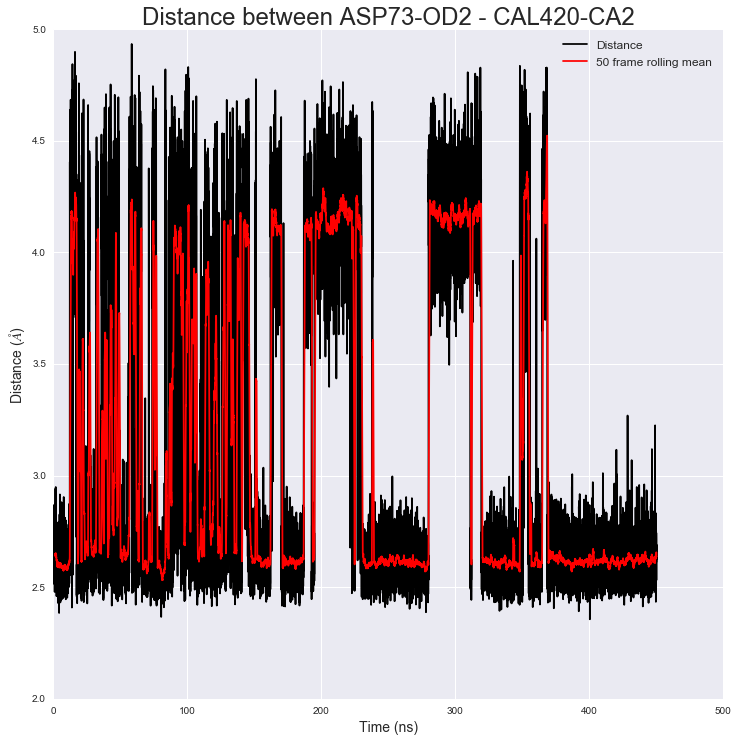

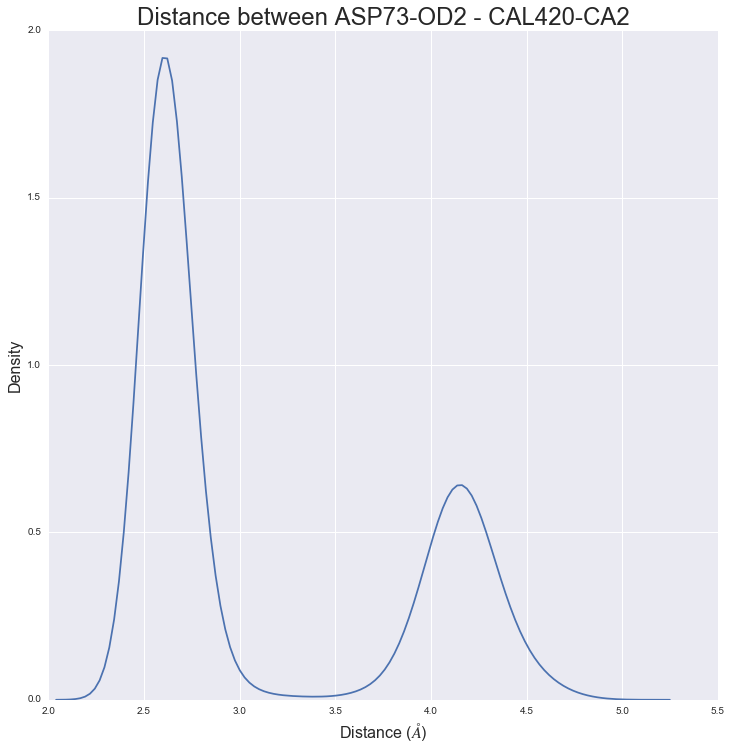

Total execution time: 8.11 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP75-OD1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


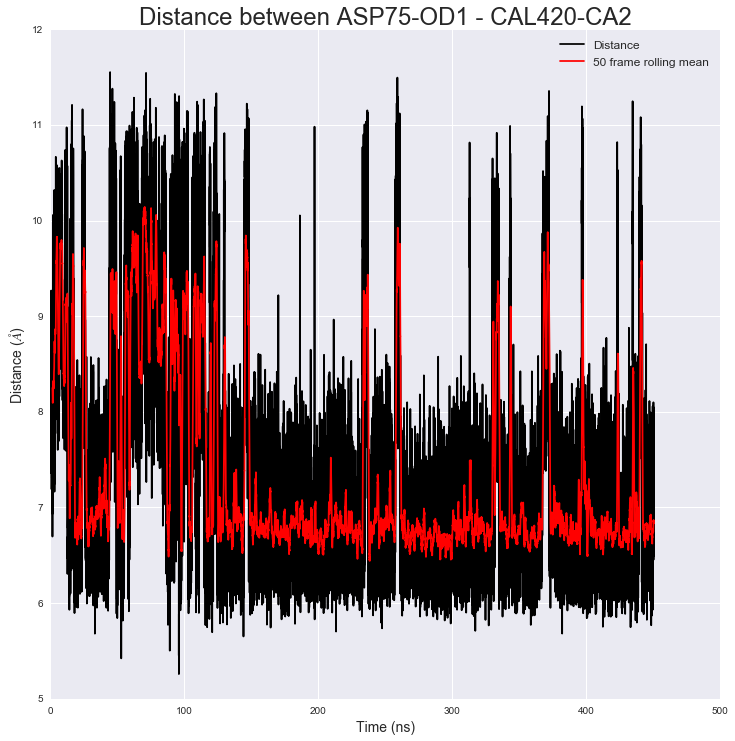

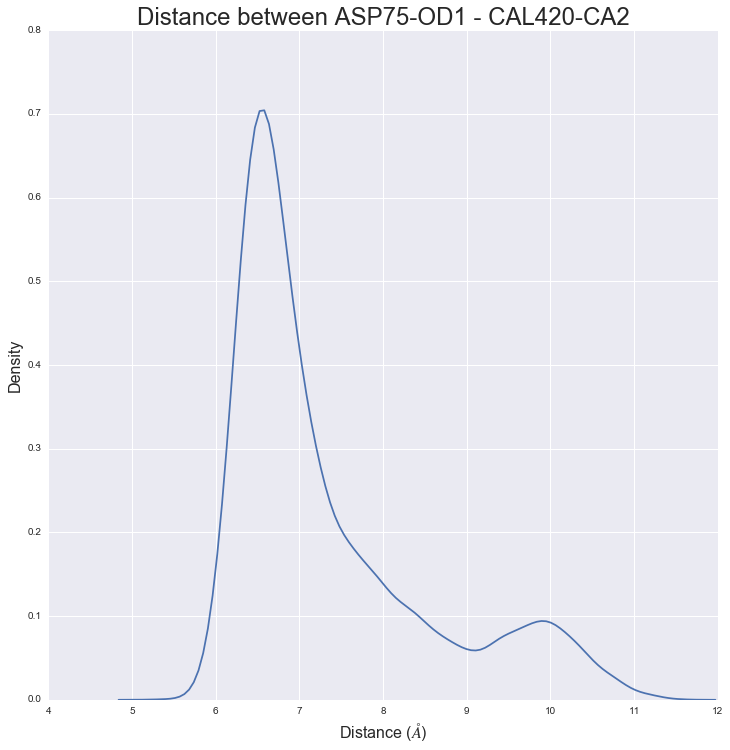

Total execution time: 8.30 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: ASP75-OD2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


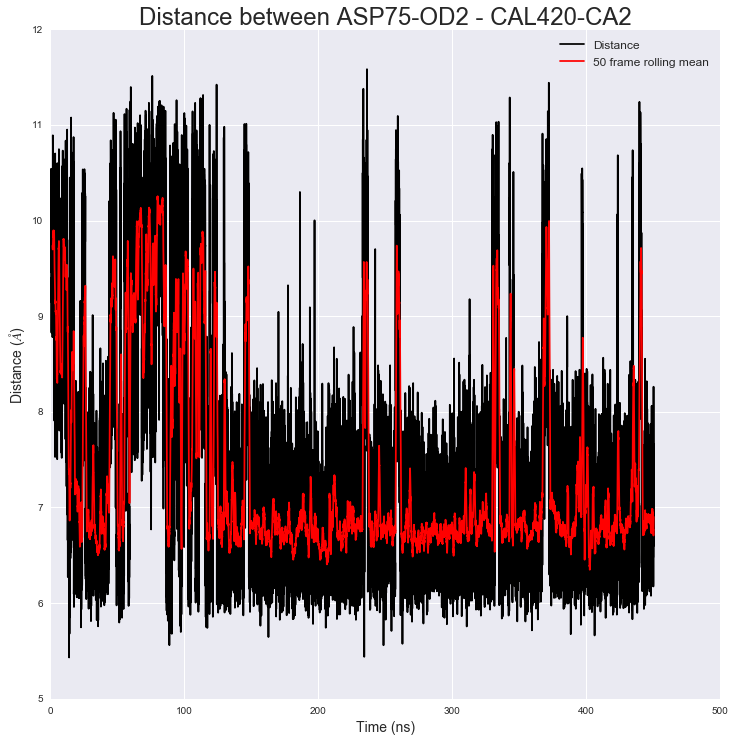

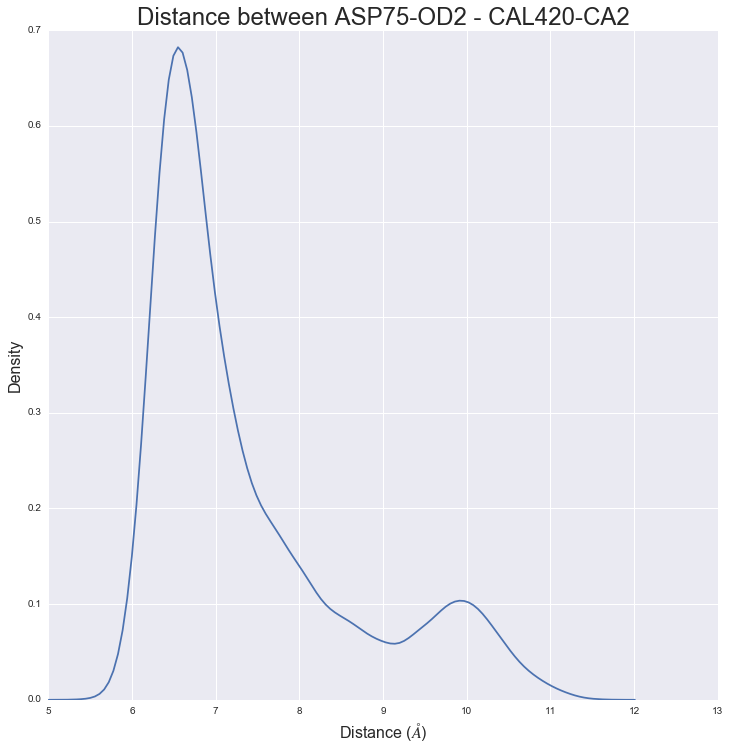

Total execution time: 8.36 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU76-OE1 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


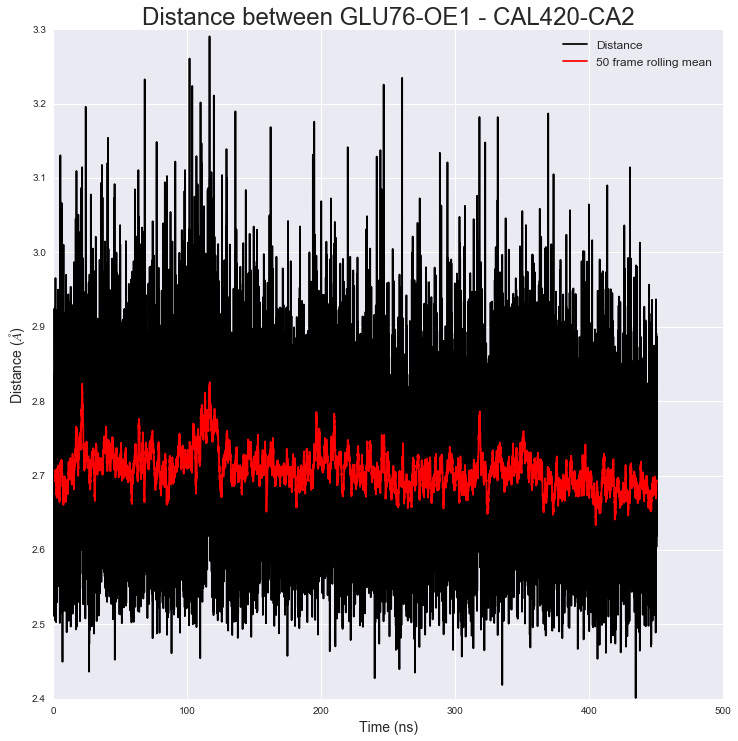

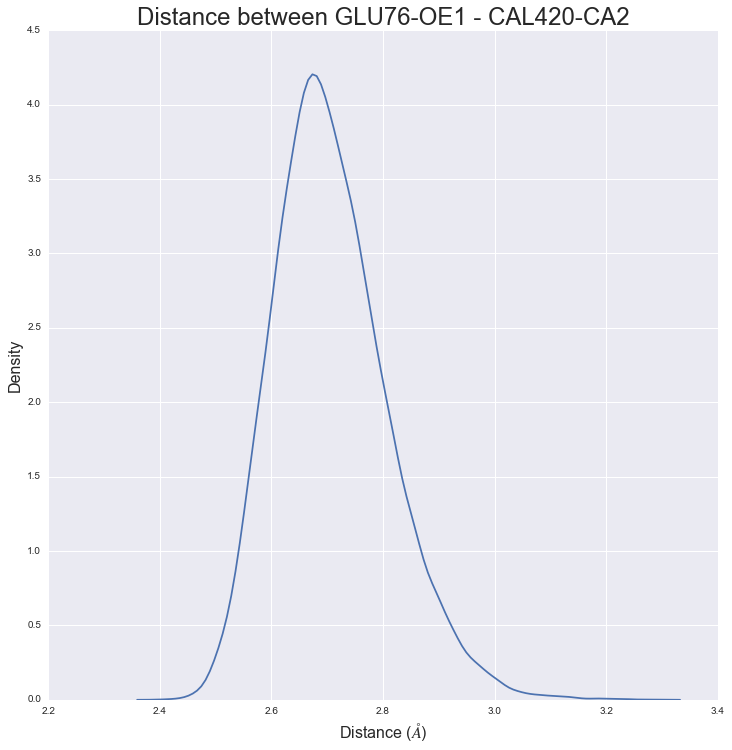

Total execution time: 8.82 seconds 

Total simulation time of all frames: 450.00 nanoseconds
The following topology file was succesfully loaded: 
 <mdtraj.Topology with 1 chains, 960 residues, 7400 atoms, 6898 bonds> 

Calculating distance between following atoms: GLU76-OE2 - CAL420-CA2 

Loading trajectories from the following files: 
05_Prod_troponin_egcg_MD5_000-050_run3_nowater.nc
05_Prod_troponin_egcg_MD5_050-100_run3_nowater.nc
05_Prod_troponin_egcg_MD5_100-150_run3_nowater.nc
05_Prod_troponin_egcg_MD5_150-200_run3_nowater.nc
05_Prod_troponin_egcg_MD5_200-250_run3_nowater.nc
05_Prod_troponin_egcg_MD5_250-300_run3_nowater.nc
05_Prod_troponin_egcg_MD5_300-350_run3_nowater.nc
05_Prod_troponin_egcg_MD5_350-400_run3_nowater.nc
05_Prod_troponin_egcg_MD5_400-450_run3_nowater.nc


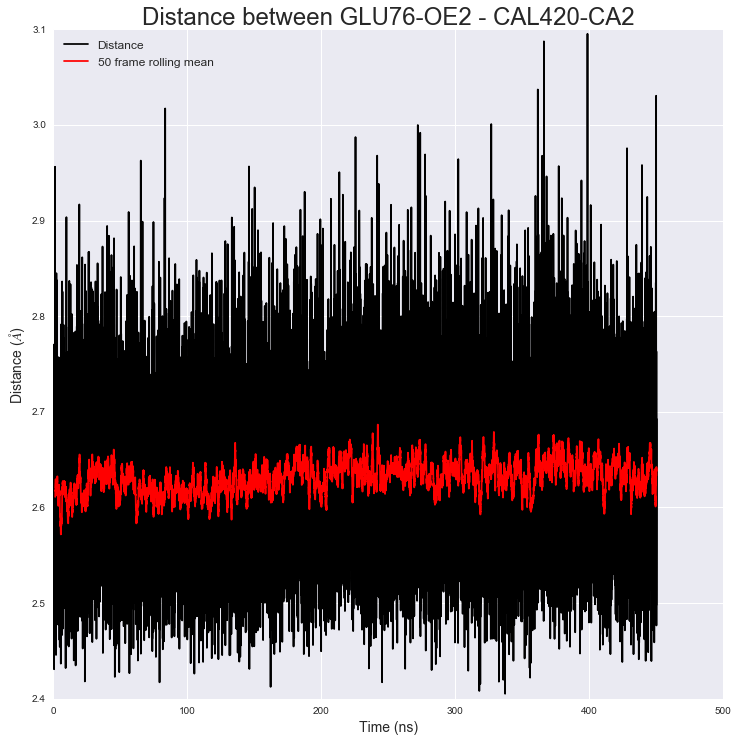

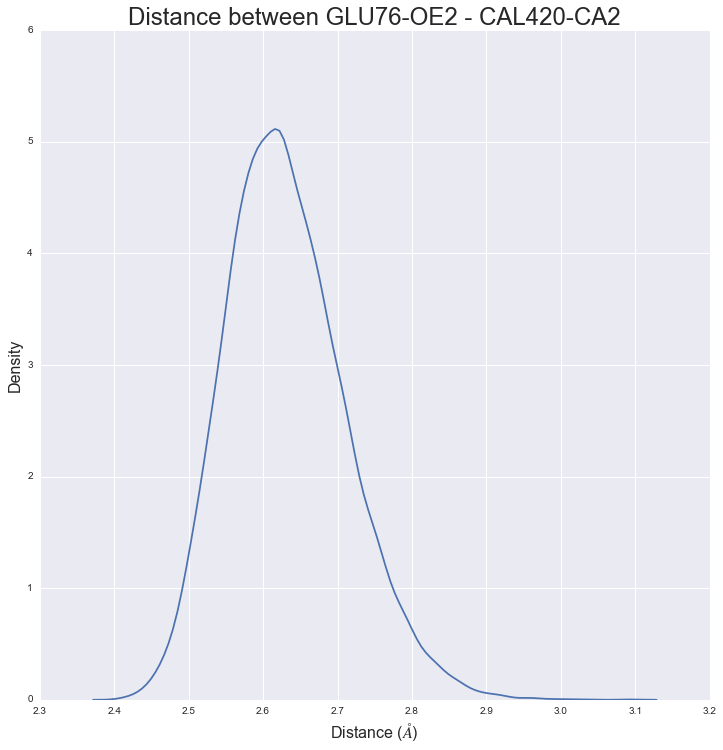

Total execution time: 8.56 seconds 

Total simulation time of all frames: 450.00 nanoseconds


In [9]:
topology_MD5 = '/Users/gil_f.hoben/Troponin_md_processed/MD5/run3/troponin_egcg_MD5_nowater.prmtop'
trajectory_MD5 = '/Users/gil_f.hoben/Troponin_md_processed/MD5/run3/Trajectories/'
for atom1 in atom1_list:
    main(topology_MD5, trajectory_MD5, atom1, atom2, verbose = 1)